In [ ]:
# === 1. Importar librerías necesarias ===
import warnings
warnings.filterwarnings("ignore")
import os
import random  # Random for generating random numbers
import torch   # PyTorch for building and training the neural network
import traceback
import numpy as np  # Numpy for data manipulation and generation of the sine wave
import pandas as pd  # Pandas for easy data manipulation and analysis
import seaborn as sns
import torch.nn as nn  # nn contains the modules for neural network layers and operations
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.pyplot as plt  # Matplotlib for plotting the results (optional)
from statsmodels.tsa.api import VAR
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import TensorDataset, DataLoader
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# === Reproducibilidad: fijar todas las semillas ===
def fijar_semillas(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Aplicar semilla
fijar_semillas(42)

In [ ]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


# 📘 Pipeline completo para modelado VAR (Vector Autoregressive)

Este flujo guía paso a paso la construcción, entrenamiento y validación de un modelo VAR para series temporales multivariadas, incluyendo prácticas como diferenciación, estandarización, evaluación, y backtesting.

---

## 1. 📥 Lectura y preparación de datos
- Cargar el dataset multivariado con fechas como índice.
- Verificar valores nulos (`NaN`) y eliminarlos si es necesario.
- Visualizar las series temporalmente.
- Confirmar que el índice temporal esté ordenado y sin duplicados.

---

## 2. ✂️ Separación en entrenamiento y prueba
- Dividir la serie multivariada en conjuntos `series_train` y `series_test`.
  - Por ejemplo: 80% para entrenamiento y 20% para prueba.
- A partir de este punto, todas las transformaciones (diferenciación, estandarización) se aprenden **solo con el conjunto de entrenamiento** y luego se aplican al conjunto de prueba.

---

## 3. 📊 Verificación de estacionariedad
- Aplicar el test de Dickey-Fuller aumentado (ADF) a cada variable en `series_train`.
- Si **p-valor > 0.05**, aplicar diferenciación `.diff()` a esa variable.
- Guardar los últimos valores antes de diferenciar para reconstruir la serie después del forecast.
- Aplicar las mismas diferencias a `series_test` sin recalcular ADF.
- Eliminar las primeras filas con `NaN`.

---

## 4. 📉 Verificación de multicolinealidad (opcional)
- Calcular `series_train.corr().abs()`.
- Si hay variables con correlación > 0.95, considerar eliminar una.

---

## 5. ⚖️ Estandarización
- Ajustar `StandardScaler()` con `series_train`.
- Transformar tanto `series_train` como `series_test` con el mismo scaler.
- Guardar el objeto `scaler` para revertir después del forecast.

---

## 6. 🔢 Selección del orden del modelo (lags)
- Usar `VAR(series_train).select_order(maxlags=N)` para determinar el mejor `p`.
- Elegir el valor óptimo usando AIC, BIC o HQIC.

---

## 7. 🧠 Entrenamiento del modelo VAR
- Ajustar el modelo: `modelo_fitted = VAR(series_train).fit(p)`.
- Revisar los coeficientes para interpretar la relación entre variables.

---

## 8. ✅ Evaluación del modelo

### a. Diagnóstico de residuos
- Obtener `residuos = modelo_fitted.resid`.
- Graficar residuos para cada variable.
- Verificar media cero, forma aleatoria y sin patrones evidentes.

### b. ACF y PACF de residuos
- Aplicar `plot_acf()` y `plot_pacf()` a los residuos.
- Confirmar ausencia de autocorrelación significativa.

### c. Prueba de Ljung-Box
- Evaluar ruido blanco con `acorr_ljungbox(residuos[col])`.

### d. Estabilidad del modelo
- `modelo_fitted.is_stable()` debe retornar `True`.

---

## 9. 📉 Predicción fuera de muestra (test)

### a. Forecast sobre conjunto de prueba
- Usar `modelo_fitted.forecast(y=series_train.values[-p:], steps=len(series_test))`.

### b. Reversión de transformaciones
- Si hay diferenciación: `cumsum()` + último valor original.
- Si hay estandarización: `scaler.inverse_transform()`.

### c. Evaluación de predicciones
- Graficar valores reales vs predichos.
- Calcular métricas:
  - MAE
  - RMSE
  - R²

### d. Comparación con modelo de persistencia (baseline)
- $$[y_{t} = y_{t-1}]$$
- Calcular métricas con esta predicción para comparar con VAR.

---

## 10. 🔁 Backtesting multistep (rolling or expanding window)

- Simula cómo habría funcionado el modelo en producción, evaluando su estabilidad y generalización.
- Para cada iteración:
  - Entrenar con una ventana (fija o creciente).
  - Predecir `h` pasos adelante.
  - Evaluar el error solo sobre los valores futuros reales.


Este flujo asegura un análisis robusto, riguroso y transparente de un modelo VAR para series temporales multivariadas.


# Lectura y visualización de las series

In [ ]:
# Lectura de la base de datos con el sistema dinámico VAR
series = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Bases_datos_finales_modelostesis/matriz_sistema_var_diario_vi.xlsx')
series.set_index('fecha', inplace=True)

# Conversión del índice a DatetimeIndex para evitar errores más adelante
series.index = pd.to_datetime(series.index)
series = series.sort_index()  # asegurarse de que esté ordenado

In [ ]:
series.head()

PIB a precios corrientes (Millones de pesos)  \
fecha                                                      
1996-12-31                                  1.449913e+07   
1997-01-01                                  1.450193e+07   
1997-01-02                                  1.450474e+07   
1997-01-03                                  1.450755e+07   
1997-01-04                                  1.451035e+07   

            Capacidad instalada de energía renovables (MW)  \
fecha                                                        
1996-12-31                                         10034.0   
1997-01-01                                         10034.0   
1997-01-02                                         10034.0   
1997-01-03                                         10034.0   
1997-01-04                                         10034.0   

            Consumo de energia electrica, (GWh)  \
fecha                                             
1996-12-31                        156488.000000   
1997-01-01                        156518.741935   
1997-01-02                        156549.483871   
1997-01-03                        156580.225806   
1997-01-04                        156610.967742   

            Rentas del petroleo (Porcentaje del PIB)  \
fecha                                                  
1996-12-31                                  3.700000   
1997-01-01                                  3.697581   
1997-01-02                                  3.695161   
1997-01-03                                  3.692742   
1997-01-04                                  3.690323   

            Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril)  \
fecha                                                                                   
1996-12-31                                          18.910000                           
1997-01-01                                          18.903548                           
1997-01-02                                          18.897097                           
1997-01-03                                          18.890645                           
1997-01-04                                          18.884194                           

            Emisiones de CO2 (Mt)  \
fecha                               
1996-12-31             341.890000   
1997-01-01             341.940565   
1997-01-02             341.991129   
1997-01-03             342.041694   
1997-01-04             342.092258   

            Uso de energía (kg de equivalente de petróleo per cápita)  \
fecha                                                                   
1996-12-31                                        1457.000000           
1997-01-01                                        1457.134409           
1997-01-02                                        1457.268817           
1997-01-03                                        1457.403226           
1997-01-04                                        1457.537634           

            Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora)  \
fecha                                                                                
1996-12-31                                       17735.000000                        
1997-01-01                                       17734.569892                        
1997-01-02                                       17734.139785                        
1997-01-03                                       17733.709677                        
1997-01-04                                       17733.279570                        

            Gasto Publico  \
fecha                       
1996-12-31  581532.900000   
1997-01-01  581925.091799   
1997-01-02  582317.548096   
1997-01-03  582710.269070   
1997-01-04  583103.254898   

            Producción de petróleo crudo (Miles de barriles por día)  
fecha                                                                 
1996-12-31                                        2861.00000

In [ ]:
series.shape

(9862, 10)

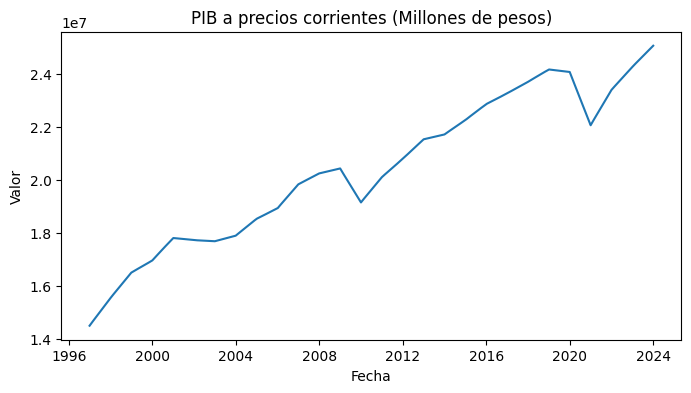

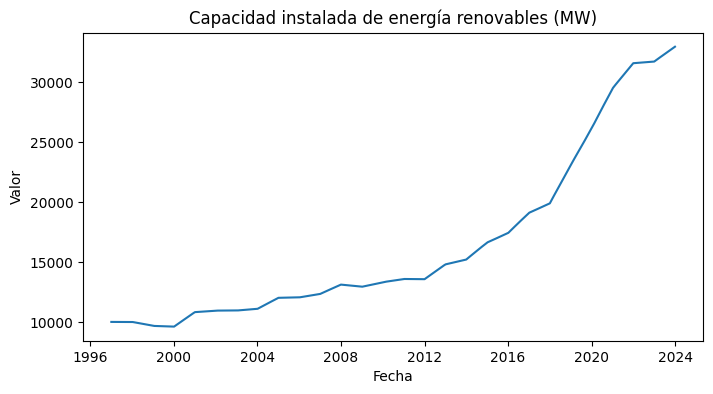

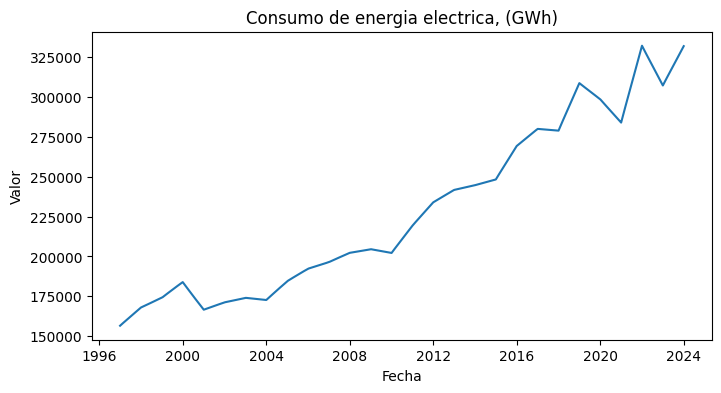

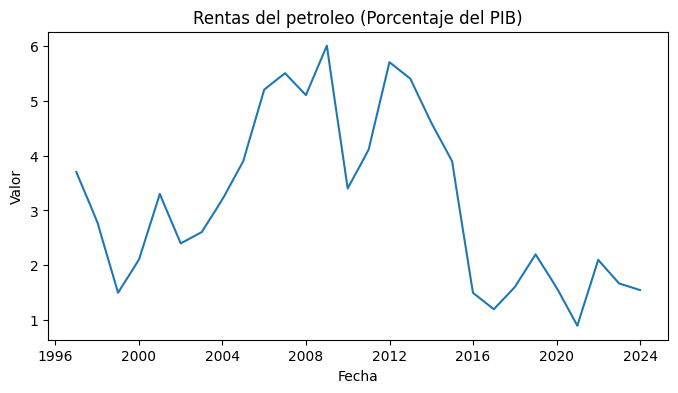

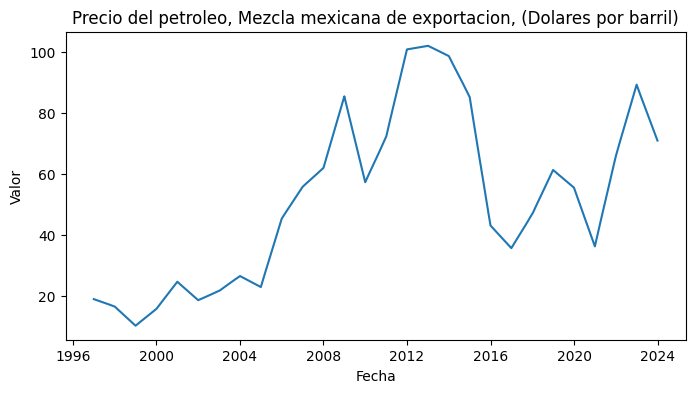

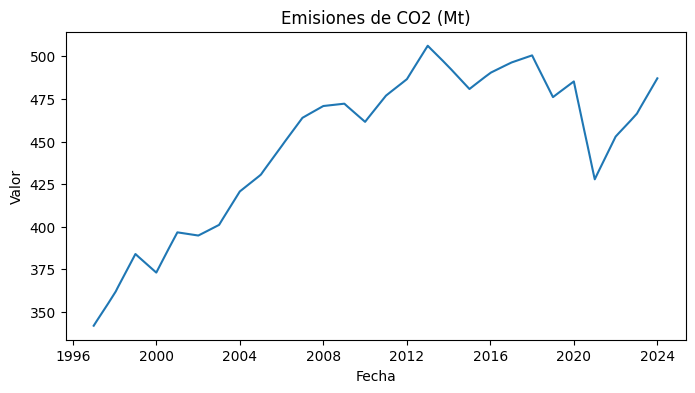

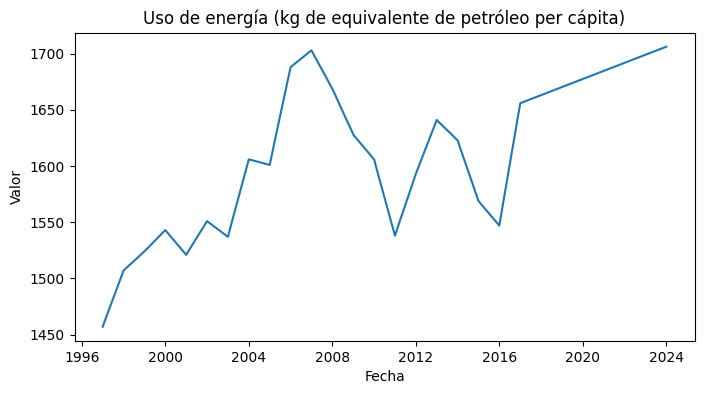

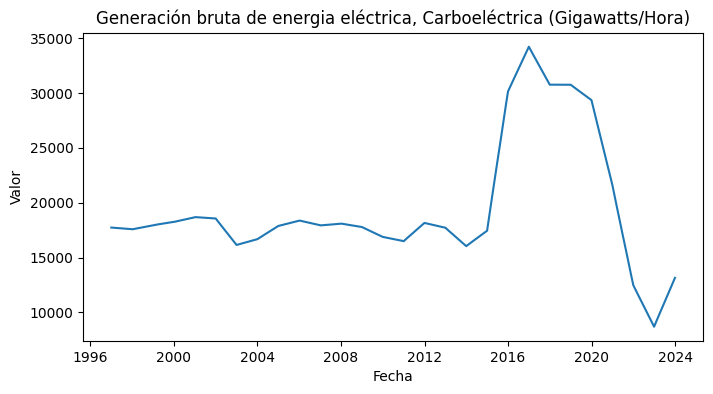

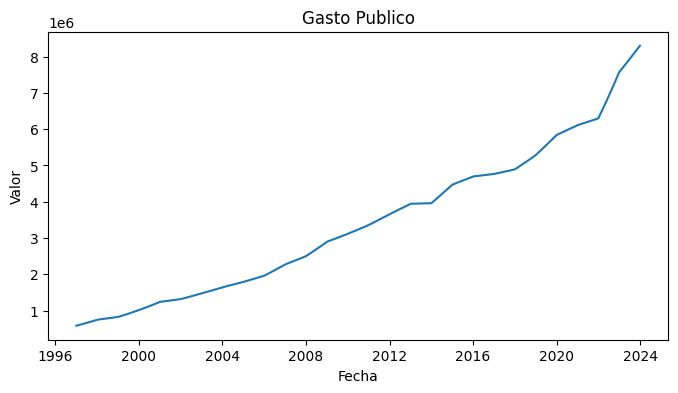

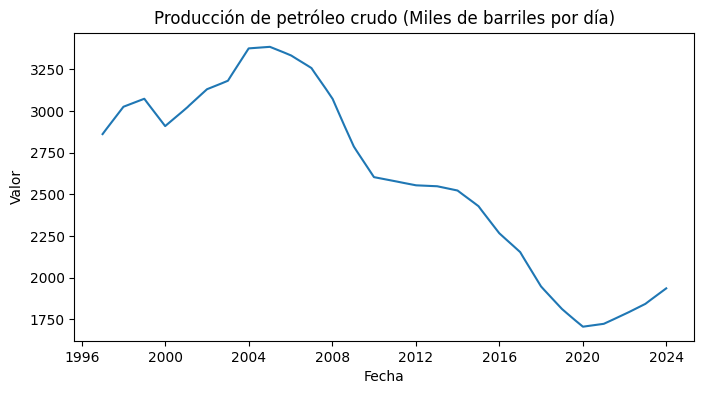

In [ ]:
# Visualización de cada una de las series
for columnas in series.columns:
  plt.figure(figsize=(8, 4))
  plt.plot(series[columnas])
  plt.title(columnas)
  plt.xlabel('Fecha')
  plt.ylabel('Valor')
  plt.show()

In [ ]:
# QC para verificar el índice temporal de nuestra serie
def verificar_indice_temporal(serie, nombre='Serie temporal'):
    """
    Revisa si el índice de la serie es un DatetimeIndex válido y continuo.
    """
    print(f"📊 Verificando índice temporal de: {nombre}")
    print("-" * 60)

    if isinstance(serie.index, pd.DatetimeIndex):
        print("✅ Índice tipo DatetimeIndex")
        print(f"⏱ Fechas: {serie.index.min().date()} ➡️ {serie.index.max().date()}")
        print(f"🔁 Frecuencia declarada: {serie.index.freq}")
        print(f"🧪 Frecuencia inferida: {pd.infer_freq(serie.index)}")
        print(f"⬆️ Índice creciente: {serie.index.is_monotonic_increasing}")
        print(f'Longitud de la serie: {len(serie)}')
        if serie.index.hasnans:
            print("⚠️ Índice contiene valores NaN.")
        else:
            print("✅ Índice sin NaN.")
    else:
        print("❌ Índice no es tipo DatetimeIndex. Considera aplicar `pd.to_datetime()`.")

    print("-" * 60)

In [ ]:
# Ejemplo de uso con tu serie
verificar_indice_temporal(series, nombre="Precio del petróleo")

📊 Verificando índice temporal de: Precio del petróleo
------------------------------------------------------------
✅ Índice tipo DatetimeIndex
⏱ Fechas: 1996-12-31 ➡️ 2023-12-31
🔁 Frecuencia declarada: None
🧪 Frecuencia inferida: D
⬆️ Índice creciente: True
Longitud de la serie: 9862
✅ Índice sin NaN.
------------------------------------------------------------



### ✅ 1. Detección de multicolinealidad

La multicolinealidad puede comprometer la estabilidad numérica del modelo VAR. Para detectarla:

- Se calculó la **matriz de correlación absoluta** entre todas las variables.
- Se identificaron los **pares altamente correlacionados**, con **correlación superior a 0.95**.
- Aunque no se eliminaron automáticamente, los pares señalados permiten al investigador tomar decisiones informadas sobre qué variables conservar.

Este análisis permite evitar redundancia y posibles singularidades en la matriz de varianzas-covarianzas al momento de ajustar el modelo.

---

> El preprocesamiento riguroso garantiza que el modelo VAR opere sobre series limpias, comparables y libres de relaciones espurias extremas entre variables.


In [ ]:
# ruta donde se guardaran resultados, gráficos, etc
ruta = '/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Predicciones_finales/VAR/Sistema_VAR_Variables_interes_tesis/'

In [ ]:
def analizar_multicolinealidad_para_VAR(series, umbral_corr=0.95, verbose=True):
    """
    Evalúa la presencia de multicolinealidad en un conjunto de series temporales multivariadas
    mediante el análisis de correlaciones lineales entre todas las variables.

    Para cada par de variables, calcula el coeficiente de correlación de Pearson absoluto y
    reporta aquellos que superan un umbral especificado, indicando posible redundancia informativa
    que podría afectar la estimación de modelos VAR.

    Parámetros:
        series (pd.DataFrame): Conjunto de series temporales multivariadas sin transformar.
        umbral_corr (float): Umbral de correlación para considerar que existe multicolinealidad (por defecto 0.95).
        verbose (bool): Si True, imprime los pares de variables con alta correlación.

    Retorna:
        correlaciones_altas (list of tuple): Lista de tuplas (var1, var2, coef) con los pares de variables
                                             cuya correlación absoluta supera el umbral especificado.
          """
    correlaciones = series.corr().abs()
    correlaciones_altas = []

    for i in range(len(correlaciones.columns)):
        for j in range(i):
            coef = correlaciones.iloc[i, j]
            if coef > umbral_corr:
                var1 = correlaciones.columns[i]
                var2 = correlaciones.columns[j]
                correlaciones_altas.append((var1, var2, coef))

    # Ordenar de mayor a menor
    correlaciones_altas.sort(key=lambda x: x[2], reverse=True)

    # Imprimir después de ordenar
    if verbose:
        for var1, var2, coef in correlaciones_altas:
            print(f"⚠️ Alta correlación: {var1} y {var2} -> {coef:.3f}")
    else:
        print("No hay alta correlación.")

    return correlaciones_altas

In [ ]:
# --Uso
# Paso 2: analizar colinealidad
correlaciones_altas = analizar_multicolinealidad_para_VAR(series, umbral_corr=0.95)

⚠️ Alta correlación: Gasto Publico y Consumo de energia electrica, (GWh) -> 0.975
⚠️ Alta correlación: Consumo de energia electrica, (GWh) y PIB a precios corrientes (Millones de pesos) -> 0.950


In [ ]:
# Función para graficar el mapa de calor de las correlaciones entre las series de tiempo
def graficar_colinealidad(series, variables=None, cmap="coolwarm", guardar_como=None):
    """
    Genera un mapa de calor de correlaciones entre variables con signo.

    Parámetros:
        series (pd.DataFrame): Series multivariadas.
        variables (list or None): Lista opcional de columnas a mostrar.
        cmap (str): Paleta de colores ("coolwarm" por defecto).
        guardar_como (str or None): Ruta para guardar la figura (opcional).
    """
    if variables is not None:
        series = series[variables]

    matriz_corr = series.corr()
    mask = np.triu(np.ones_like(matriz_corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.set(style="white")

    sns.heatmap(
        matriz_corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlación"}
    )

    plt.title("Mapa de calor de correlaciones (con signo)", fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    if guardar_como:
        plt.savefig(guardar_como, dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

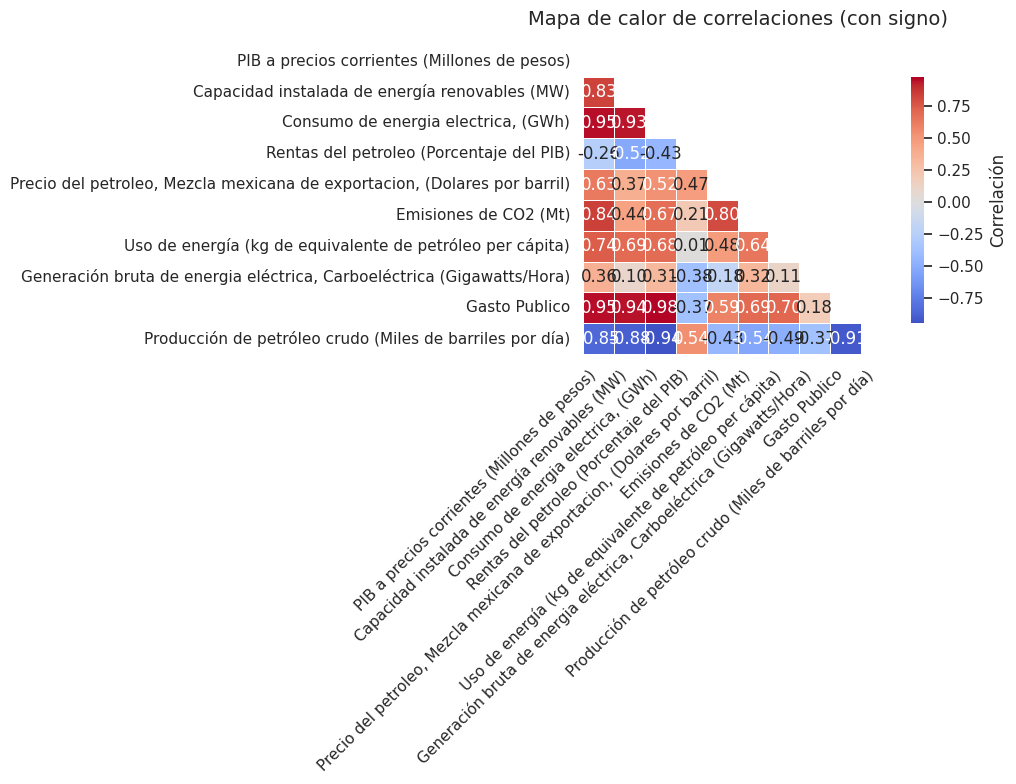

In [ ]:
# --Uso
graficar_colinealidad(series, variables=None, cmap="coolwarm", guardar_como = ruta + 'Heat_map_inicial.png')

# Limpieza de las series para modelo VAR despúes del análisis de colinealidad

> 📌 **Nota aclaratoria sobre correlación y colinealidad en modelos VAR**

En modelos multivariados como el VAR, es importante comprender la diferencia entre dos conceptos relacionados pero distintos: **correlación** y **colinealidad**.

---

### 🔹 Correlación

- Mide la **fuerza y dirección** de la relación lineal entre dos variables.
- Se expresa con el coeficiente `r`, que toma valores entre `-1` y `+1`.
- Una **correlación moderada o fuerte (por ejemplo, r entre 0.5 y 0.8)** es deseable, ya que indica que una variable puede aportar información útil para predecir otra.

---

### 🔻 Colinealidad (o multicolinealidad)

- Es un **problema estructural** que ocurre cuando una variable es **casi una combinación lineal de otras**.
- Usualmente se detecta cuando dos variables tienen **correlación extrema (r > 0.95 o ≈ 1.0)**.
- Genera problemas como:
  - Coeficientes inestables o sin interpretación.
  - Singularidades numéricas durante el ajuste.
  - Pérdida de robustez en las predicciones.

---

### 🎯 Regla práctica:

> ✔️ Queremos **correlación funcional** entre variables para que el modelo capture dependencias útiles.  
> ❌ No queremos **colinealidad extrema**, que representa **redundancia destructiva**.

---

### 🧠 Resumen visual

| Tipo de relación             | ¿Correlación? | ¿Colinealidad? | Acción recomendada        |
|------------------------------|----------------|----------------|----------------------------|
| r = 0.6 entre A y B          | ✔️ Sí         | ❌ No         | Mantener ambas variables   |
| r = 0.98 entre A y B         | ✔️ Sí         | ✔️ Sí         | Eliminar una variable      |
| A = 2 × B + 0.001 (casi igual) | ✔️ Sí         | ✔️ Crítica    | Colinealidad perfecta → eliminar |

---

Este principio aplica especialmente en modelos VAR, donde **todas las variables actúan como predictoras y objetivo al mismo tiempo**, lo que hace que la colinealidad afecte **todo el sistema dinámico**.


In [ ]:
# Series originales pero sin las series que quitamos para evitar multicolinealidad en las series que alimentaran el modelo VAR
series_sin_multicolinealidad = series.drop(columns=['Consumo de energia electrica, (GWh)'])

In [ ]:
series_sin_multicolinealidad.shape

(9862, 9)

In [ ]:
# Guardar series_sin_multicolinealidad para predecir Precio del Petroleo con un modelo de Deep Learning más avanzado
#series_sin_multicolinealidad.to_excel('/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Bases_datos_finales_modelostesis/matriz_pre_pet_diario_LSTM.xlsx')

#### ✅ 2. Verificación de estacionariedad

Cada serie fue evaluada mediante el **test de Dickey-Fuller aumentado (ADF)**. En caso de obtener un **p-valor mayor a 0.05**, se aplicó una **diferenciación de primer orden** para inducir estacionariedad. Este paso es crucial porque el modelo VAR asume que todas las variables son estacionarias.



In [ ]:
# Función de procesamiento (diferenciación - estandarización) de las series para el modelo VAR
def preprocesar_series_para_VAR(series, alpha=0.05, umbral_corr=0.90, verbose=True):
    """
    Verifica estacionariedad, aplica diferenciación si es necesario,
    detecta multicolinealidad y estandariza todas las series.

    Parámetros:
        series (pd.DataFrame): Serie multivariada con índice temporal.
        alpha (float): Nivel de significancia para ADF.
        umbral_corr (float): Umbral para identificar multicolinealidad extrema.
        verbose (bool): Si True, imprime información diagnóstica.

    Retorna:
        series_scaled (pd.DataFrame): Series transformadas (diferenciadas si es necesario y estandarizadas).
        estacionariedad (dict): Si la serie original era estacionaria.
        scaler (StandardScaler): Objeto para revertir la estandarización.
        correlaciones_altas (list of tuple): Pares de variables con alta correlación.
        variables_diferenciadas (list): Lista de variables que fueron diferenciadas.
    """
    series_var = series.copy()
    estacionariedad = {}

    # 1. Verificar estacionariedad y diferenciar
    for col in series_var.columns:
        resultado = adfuller(series_var[col].dropna(), autolag='AIC')
        p_valor = resultado[1]
        es_estacionaria = p_valor < alpha
        estacionariedad[col] = es_estacionaria
        if verbose:
            print(f"{col}: {'Estacionaria' if es_estacionaria else 'NO estacionaria'} (p-valor = {p_valor:.4f})")
        if not es_estacionaria:
            series_var[col] = series_var[col].diff()

    series_var = series_var.dropna()
    variables_diferenciadas = [col for col, est in estacionariedad.items() if not est]

    # 2. Verificar multicolinealidad
    correlaciones_altas = analizar_multicolinealidad_para_VAR(series_var, umbral_corr=umbral_corr, verbose=verbose)

    return series_var, estacionariedad, correlaciones_altas, variables_diferenciadas

In [ ]:
#--Uso--
series_var, estacionariedad, correlaciones_altas, variables_diferenciadas = preprocesar_series_para_VAR(series_sin_multicolinealidad)

# Verificar pares altamente correlacionados y variables diferenciadas
if variables_diferenciadas:
    print("\nVariables diferenciadas para lograr estacionariedad:")
    for var in variables_diferenciadas:
        print(f"• {var}")
else:
    print("\nTodas las variables eran estacionarias.")

print(f"\nSerie final para el modelo VAR contiene {series_var.shape[1]} variables y {series_var.shape[0]} observaciones.")

PIB a precios corrientes (Millones de pesos): NO estacionaria (p-valor = 0.7445)
Capacidad instalada de energía renovables (MW): NO estacionaria (p-valor = 0.9927)
Rentas del petroleo (Porcentaje del PIB): NO estacionaria (p-valor = 0.1357)
Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril): NO estacionaria (p-valor = 0.0867)
Emisiones de CO2 (Mt): NO estacionaria (p-valor = 0.2505)
Uso de energía (kg de equivalente de petróleo per cápita): NO estacionaria (p-valor = 0.1312)
Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora): Estacionaria (p-valor = 0.0123)
Gasto Publico: NO estacionaria (p-valor = 0.9988)
Producción de petróleo crudo (Miles de barriles por día): NO estacionaria (p-valor = 0.5482)

Variables diferenciadas para lograr estacionariedad:
• PIB a precios corrientes (Millones de pesos)
• Capacidad instalada de energía renovables (MW)
• Rentas del petroleo (Porcentaje del PIB)
• Precio del petroleo, Mezcla mexicana de exportacion, (D

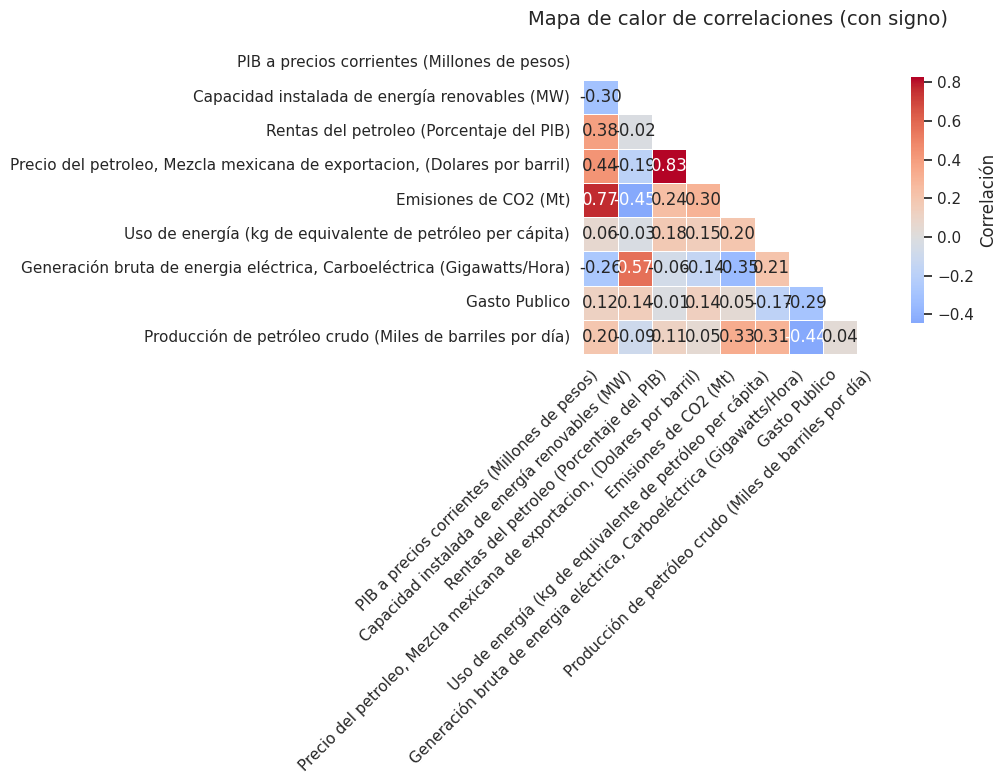

In [ ]:
# --Uso
graficar_colinealidad(series_var, variables=None, cmap="coolwarm", guardar_como = ruta + 'Heat_map_final_VAR.png')

In [ ]:
series_var.head()

PIB a precios corrientes (Millones de pesos)  \
fecha                                                      
1997-01-01                                      2805.845   
1997-01-02                                      2805.845   
1997-01-03                                      2805.845   
1997-01-04                                      2805.845   
1997-01-05                                      2805.845   

            Capacidad instalada de energía renovables (MW)  \
fecha                                                        
1997-01-01                                             0.0   
1997-01-02                                             0.0   
1997-01-03                                             0.0   
1997-01-04                                             0.0   
1997-01-05                                             0.0   

            Rentas del petroleo (Porcentaje del PIB)  \
fecha                                                  
1997-01-01                                 -0.002419   
1997-01-02                                 -0.002419   
1997-01-03                                 -0.002419   
1997-01-04                                 -0.002419   
1997-01-05                                 -0.002419   

            Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril)  \
fecha                                                                                   
1997-01-01                                          -0.006452                           
1997-01-02                                          -0.006452                           
1997-01-03                                          -0.006452                           
1997-01-04                                          -0.006452                           
1997-01-05                                          -0.006452                           

            Emisiones de CO2 (Mt)  \
fecha                               
1997-01-01               0.050565   
1997-01-02               0.050565   
1997-01-03               0.050565   
1997-01-04               0.050565   
1997-01-05               0.050565   

            Uso de energía (kg de equivalente de petróleo per cápita)  \
fecha                                                                   
1997-01-01                                           0.134409           
1997-01-02                                           0.134409           
1997-01-03                                           0.134409           
1997-01-04                                           0.134409           
1997-01-05                                           0.134409           

            Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora)  \
fecha                                                                                
1997-01-01                                       17734.569892                        
1997-01-02                                       17734.139785                        
1997-01-03                                       17733.709677                        
1997-01-04                                       17733.279570                        
1997-01-05                                       17732.849462                        

            Gasto Publico  \
fecha                       
1997-01-01     392.191799   
1997-01-02     392.456297   
1997-01-03     392.720974   
1997-01-04     392.985829   
1997-01-05     393.250862   

            Producción de petróleo crudo (Miles de barriles por día)  
fecha                                                                 
1997-01-01                                            0.44086         
1997-01-02                                            0.44086         
1997-01-03                                            0.44086         
1997-01-04                                            0.44086         
1997-01-05                                            0.44086

In [ ]:
series_var.shape

(9861, 9)

# División temporal en conjunto de entrenamiento y prueba

In [ ]:
def dividir_series_VAR(series, proporcion_entrenamiento=0.8):
    """
    Divide una serie multivariada en conjuntos de entrenamiento y prueba temporalmente.

    Parámetros:
        series (pd.DataFrame): Serie multivariada preprocesada (diferenciada y estandarizada).
        proporcion_entrenamiento (float): Proporción para el conjunto de entrenamiento.

    Retorna:
        series_train (pd.DataFrame): Conjunto de entrenamiento.
        series_test (pd.DataFrame): Conjunto de prueba.
    """
    n_total = len(series)
    n_train = int(n_total * proporcion_entrenamiento)

    train_series = series.iloc[:n_train].copy()
    test_series = series.iloc[n_train:].copy()

    return train_series, test_series


In [ ]:
# Separar la base en train y test (e.g., 80/20)
train_series, test_series = dividir_series_VAR(series_var, proporcion_entrenamiento=0.8)

# Confirmar tamaños
print(f"🔹 Tamaño entrenamiento: {train_series.shape}")
print(f"🔹 Tamaño prueba: {test_series.shape}")

🔹 Tamaño entrenamiento: (7888, 9)
🔹 Tamaño prueba: (1973, 9)


In [ ]:
# QC: Prueba de estacionariedad auxiliar a ADF (KPSS la cual se considera más robusta)
## * Realizar como segundo QC para asegurarse que las series diferenciadas en realidad YA SON ESTACIONARIAS

for col in train_series.columns:
    resultado = kpss(train_series[col].dropna(), regression='c', nlags='auto')
    p_valor = resultado[1]
    es_estacionario = p_valor < 0.05
    print(f"{col}: {'Estacionaria' if es_estacionario else 'NO estacionaria'} (p-valor = {p_valor:.4f})")


PIB a precios corrientes (Millones de pesos): Estacionaria (p-valor = 0.0192)
Capacidad instalada de energía renovables (MW): Estacionaria (p-valor = 0.0100)
Rentas del petroleo (Porcentaje del PIB): Estacionaria (p-valor = 0.0100)
Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril): Estacionaria (p-valor = 0.0100)
Emisiones de CO2 (Mt): Estacionaria (p-valor = 0.0100)
Uso de energía (kg de equivalente de petróleo per cápita): Estacionaria (p-valor = 0.0187)
Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora): Estacionaria (p-valor = 0.0100)
Gasto Publico: Estacionaria (p-valor = 0.0100)
Producción de petróleo crudo (Miles de barriles por día): Estacionaria (p-valor = 0.0100)


/tmp/ipython-input-3294492518.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado = kpss(train_series[col].dropna(), regression='c', nlags='auto')
/tmp/ipython-input-3294492518.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado = kpss(train_series[col].dropna(), regression='c', nlags='auto')
/tmp/ipython-input-3294492518.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado = kpss(train_series[col].dropna(), regression='c', nlags='auto')
/tmp/ipython-input-3294492518.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

#### ✅ 3. Estandarización individual para conjunto de entrenamiento y prueba

Una vez estacionarias, las series fueron **escaladas con media cero y desviación estándar uno** mediante `StandardScaler`. Esto es importante porque en el modelo VAR todas las variables se tratan de forma simultánea y deben estar en una **escala comparable**.

---

In [ ]:
def estandarizar_train_test(train_df, test_df):
    """
    Estandariza las variables del conjunto de entrenamiento y aplica la transformación al conjunto de prueba.

    Parámetros:
        train_df (pd.DataFrame): Conjunto de entrenamiento (series diferenciadas o originales).
        test_df (pd.DataFrame): Conjunto de prueba (mismo orden y columnas que train_df).

    Retorna:
        train_scaled (pd.DataFrame): Entrenamiento estandarizado.
        test_scaled (pd.DataFrame): Prueba estandarizada.
        scaler (StandardScaler): Objeto scaler ajustado sobre el entrenamiento.
    """
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_df),
        columns=train_df.columns,
        index=train_df.index
    )

    test_scaled = pd.DataFrame(
        scaler.transform(test_df),
        columns=test_df.columns,
        index=test_df.index
    )

    return train_scaled, test_scaled, scaler

## 🔄 ¿Por qué estandarizar **después** de dividir en entrenamiento y prueba?

En modelos predictivos, especialmente en series temporales, es crucial evitar **fugas de información (data leakage)**. Esto ocurre cuando información del conjunto de prueba influye en el entrenamiento del modelo, directa o indirectamente.

### ⚠️ Si estandarizamos **antes** de dividir:
- El `StandardScaler` calcularía la media y desviación estándar **usando toda la serie**, incluyendo datos futuros (del conjunto de prueba).
- Esto introduce sesgo, ya que el modelo estaría "viendo el futuro" al entrenar.

### ✅ Al estandarizar **después** de dividir:
- Calculamos la media y desviación **solo con el conjunto de entrenamiento**.
- Luego, aplicamos esa transformación al conjunto de prueba.
- Esto simula correctamente un entorno real, donde el modelo aprende del pasado y generaliza al futuro sin conocerlo.

Este principio es fundamental para asegurar la **validez de las métricas de evaluación** y la **generalización del modelo**.


In [ ]:
# Estandarizar solo después de dividir
train_series, test_series, scaler = estandarizar_train_test(train_series, test_series)


# 📌 Selección del número óptimo de rezagos (lags) en el modelo VAR

Una de las decisiones más importantes en la construcción de un modelo VAR (Vector Autoregressive) es elegir el número óptimo de rezagos `p`. Este valor determina cuántos periodos pasados de cada variable se utilizan para predecir los valores actuales y futuros del sistema.

---

#### ✅ ¿Cómo se selecciona el lag óptimo?

Utilizamos un enfoque robusto basado en **criterios de información estadísticos**, los cuales balancean el ajuste del modelo con su complejidad:

- **AIC (Akaike Information Criterion)**: Favorece modelos con mejor ajuste, puede sobreajustar si el tamaño de muestra es pequeño.
- **BIC (Bayesian Information Criterion)**: Favorece modelos más simples, ideal para evitar sobreajuste.
- **HQIC y FPE**: Otros criterios de respaldo con propiedades similares.

El modelo VAR se entrena con múltiples valores de `p`, y se selecciona el que **minimice alguno de estos criterios**, usualmente AIC o BIC.

---

#### 🧠 Estabilidad del modelo

Una vez seleccionado el lag óptimo, es fundamental verificar que el modelo sea **estable**. Esto significa que todas las raíces del polinomio característico del VAR estén **dentro del círculo unitario**. La estabilidad garantiza que las perturbaciones en el sistema se disipan con el tiempo.

---

#### 📊 Visualización de criterios

Además del valor óptimo, se genera una visualización comparativa de los criterios para cada lag. Esto permite verificar si existe un "valle claro" o si los valores son similares en varios rezagos, lo cual puede justificar una elección más conservadora.

---

> Este enfoque permite tomar una decisión informada, estadísticamente justificada y robusta, antes de entrenar el modelo final.

---

#### 🧠 Regla práctica basada en tamaño muestral

Para evitar sobreajuste y asegurar estimabilidad, se recomienda:

$$n_{\text{obs}} \gg p \cdot k^2$$

Donde:
$$ n_{\text{obs}}: $$ es el número de observaciones disponibles.
$$ p:$$ es el número de rezagos.
$$ k: $$ es el número de variables.

Esta regla permite determinar un valor máximo razonable para `p`.

---


# Selección automática del lag (rezago) óptimo (p)

In [ ]:
# Función para seleccionar el lag (rezago) óptimo del modelo VAR
# Versión completamente automática que evalúa criterios para cada p de 0 a maxlags
def seleccionar_lag_optimo_manual(series_var, maxlags=15, criterio='AIC', graficar=False, exportar_csv=None):
    """
    Selecciona el lag óptimo para un modelo VAR evaluando manualmente los criterios en cada p.

    Parámetros:
        series_var (pd.DataFrame): Serie multivariada para entrenamiento.
        maxlags (int): Número máximo de rezagos a probar.
        criterio (str): Criterio para seleccionar el lag óptimo ('AIC', 'BIC', 'FPE', 'HQIC').
        graficar (bool): Si True, muestra gráfico de los criterios por lag.
        exportar_csv (str or None): Ruta para exportar el resumen a CSV (opcional).

    Retorna:
        lag_optimo (int): Lag óptimo según el criterio.
        resumen (pd.DataFrame): Tabla con valores por criterio y p.
    """
    criterio = criterio.upper()
    criterios_validos = ['AIC', 'BIC', 'FPE', 'HQIC']
    if criterio not in criterios_validos:
        raise ValueError(f"❌ Criterio no válido: {criterio}. Usa uno de {criterios_validos}")

    resultados = {k: [] for k in criterios_validos}
    lags_probados = []

    for p in range(0, maxlags + 1):
        try:
            modelo_fitted = VAR(series_var).fit(p)
            resultados['AIC'].append(modelo_fitted.aic)
            resultados['BIC'].append(modelo_fitted.bic)
            resultados['HQIC'].append(modelo_fitted.hqic)
            resultados['FPE'].append(modelo_fitted.fpe)
            lags_probados.append(p)
        except Exception:
            # Si el modelo no se puede ajustar para cierto p, guardar NaN
            for key in resultados:
                resultados[key].append(np.nan)
            lags_probados.append(p)

    resumen = pd.DataFrame(resultados, index=lags_probados)

    if exportar_csv:
        resumen.to_csv(exportar_csv)

    if graficar:
        plt.figure(figsize=(10, 6))
        for col in resumen.columns:
            plt.plot(resumen.index, resumen[col], marker='o', label=col)
        plt.xlabel("Número de rezagos (p)")
        plt.ylabel("Valor del criterio")
        plt.title("Criterios de información por número de rezagos (estimación manual)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if criterio in resumen.columns:
        lag_optimo = resumen[criterio].idxmin()
        print(f"\n✅ Lag óptimo según {criterio}: {lag_optimo}")
    else:
        lag_optimo = None
        print(f"⚠️ {criterio} no disponible. No se determinó lag óptimo.")

    return lag_optimo, resumen

## 📊 Comparación de Criterios de Información en Modelos VAR

| **Criterio** | **¿Qué busca?**                        | **Penaliza complejidad** | **Mejor para...**                |
|--------------|-----------------------------------------|----------------------------|----------------------------------|
| **AIC**      | Buen ajuste general del modelo          | Moderadamente              | Entrenamiento / ajuste           |
| **BIC**      | Generalización y parsimonia             | Fuerte                     | Validación / producción          |
| **HQIC**     | Equilibrio entre AIC y BIC              | Intermedia                 | Modelos balanceados              |
| **FPE**      | Mínimo error de predicción futura       | Implícitamente (via varianza) | Predicción multivariada a futuro |

---

### 🧠 Interpretaciones clave:

- **AIC (Akaike Information Criterion)**  
  Penaliza la complejidad con `2k`. Prefiere modelos con buen ajuste, aunque más complejos.

- **BIC (Bayesian Information Criterion)**  
  Penaliza con `k * ln(n)`. Prefiere modelos más simples, ideal para generalizar mejor fuera de muestra.

- **HQIC (Hannan-Quinn)**  
  Penalización `2k * ln(ln(n))`. Ofrece una solución intermedia entre AIC y BIC.

- **FPE (Final Prediction Error)**  
  Estimación directa del error cuadrático medio fuera de muestra. Muy útil en modelos VAR.

---

### ✅ Recomendaciones prácticas:

- Usa **AIC** si buscas capturar toda la dinámica (incluso compleja).
- Usa **BIC** si prefieres un modelo más simple y robusto a nuevas observaciones.
- Usa **FPE** si tu objetivo es la **predicción futura multivariada**.
- Comparar todos en conjunto te da una mejor base para elegir el lag óptimo.


In [ ]:
print(f"Nº de observaciones: {len(train_series)}")
print(f"Nº de variables: {train_series.shape[1]}")


Nº de observaciones: 7888
Nº de variables: 9


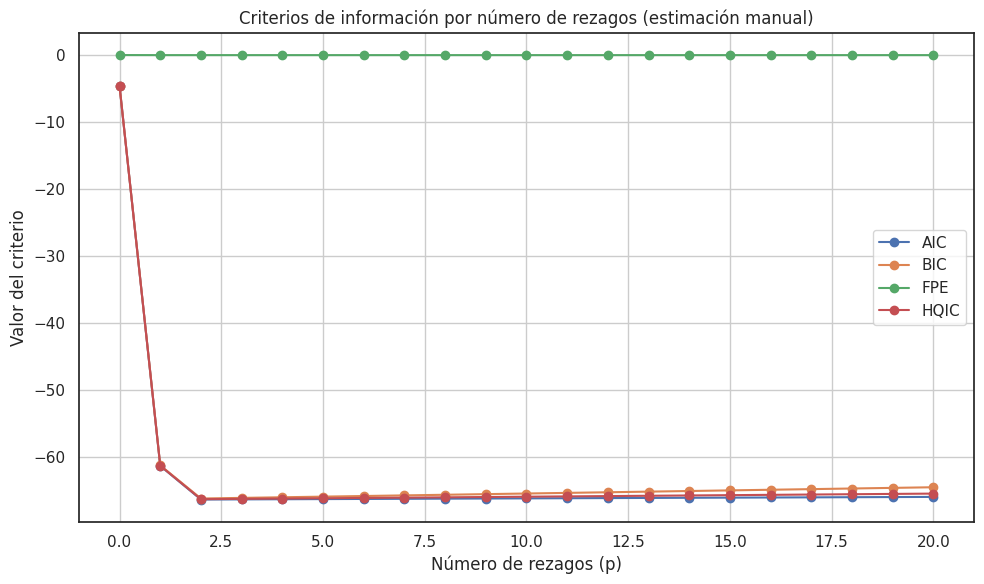


✅ Lag óptimo según AIC: 2


In [ ]:
#-- Uso
train_series.index.freq = pd.infer_freq(train_series.index)
lag_optimo, resumen_criterios = seleccionar_lag_optimo_manual(
    train_series,
    maxlags=20,
    criterio='AIC',
    graficar=True,
    exportar_csv= ruta + "criterios_VAR.csv"
)

In [ ]:
resumen_criterios

AIC        BIC           FPE       HQIC
0   -4.636848  -4.628892  9.688187e-03  -4.634123
1  -61.356367 -61.276797  2.255634e-27 -61.329112
2  -66.378623 -66.227424  1.486382e-29 -66.326832
3  -66.356964 -66.134120  1.518927e-29 -66.280632
4  -66.335299 -66.040795  1.552194e-29 -66.234421
5  -66.313630 -65.947449  1.586197e-29 -66.188200
6  -66.291955 -65.854083  1.620954e-29 -66.141967
7  -66.270275 -65.760696  1.656482e-29 -66.095724
8  -66.248590 -65.667288  1.692798e-29 -66.049469
9  -66.226900 -65.573859  1.729919e-29 -66.003204
10 -66.205204 -65.480410  1.767865e-29 -65.956928
11 -66.183503 -65.386940  1.806654e-29 -65.910641
12 -66.161798 -65.293449  1.846305e-29 -65.864343
13 -66.140086 -65.199937  1.886836e-29 -65.818035
14 -66.118370 -65.106404  1.928269e-29 -65.771715
15 -66.096649 -65.012851  1.970624e-29 -65.725385
16 -66.074922 -64.919276  2.013921e-29 -65.679044
17 -66.053190 -64.825681  2.058181e-29 -65.632692
18 -66.031453 -64.732065  2.103428e-29 -65.586329
19 -66.009710 -64.638428  2.149682e-29 -65.539955
20 -65.987963 -64.544770  2.196967e-29 -65.493570

# Selección manual del lag óptimo (p) mediante análisis de PACF

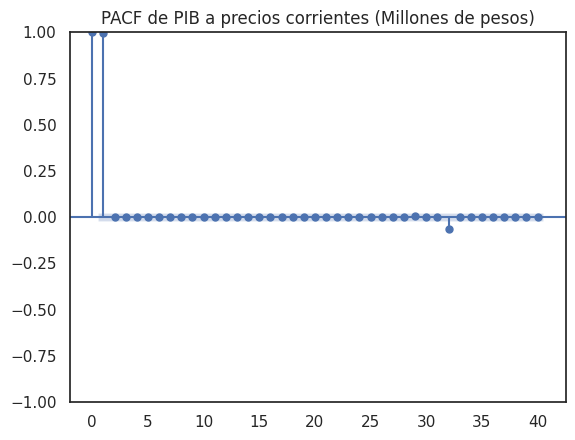

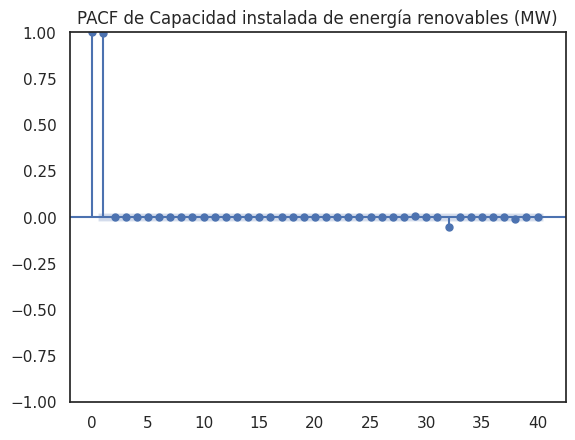

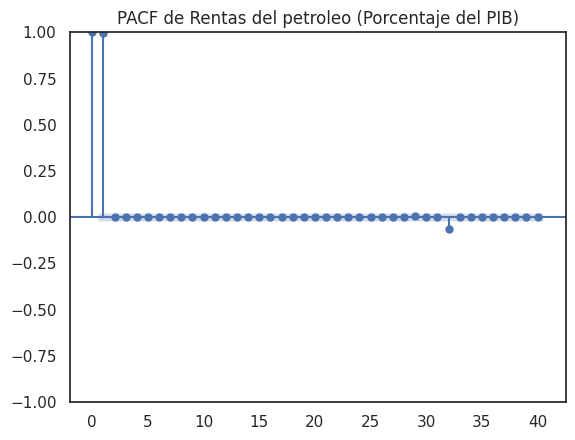

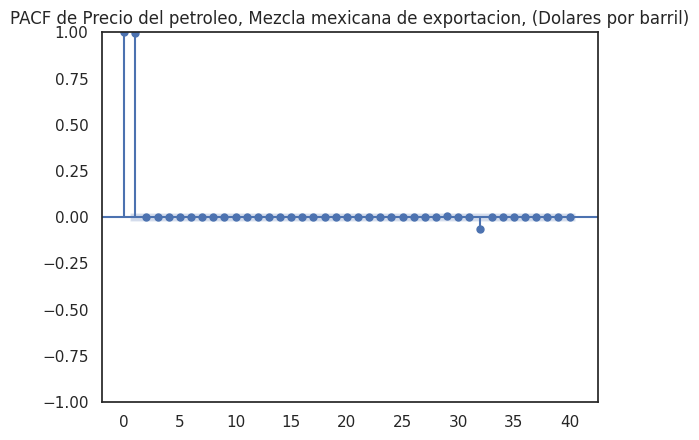

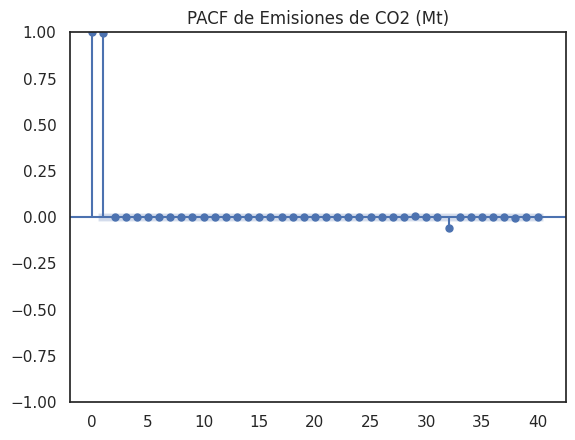

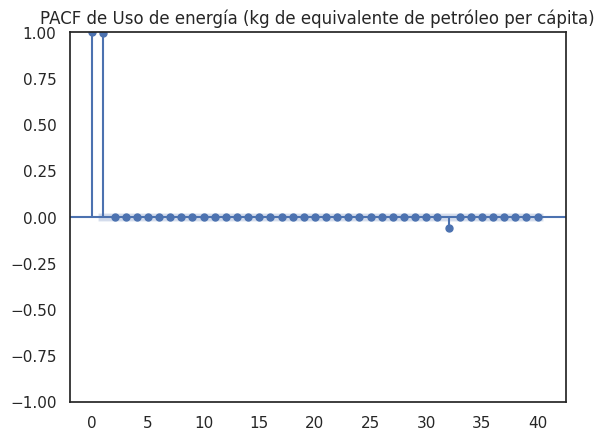

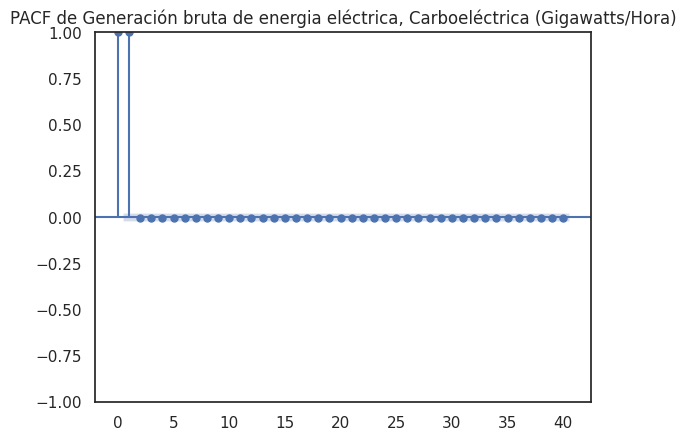

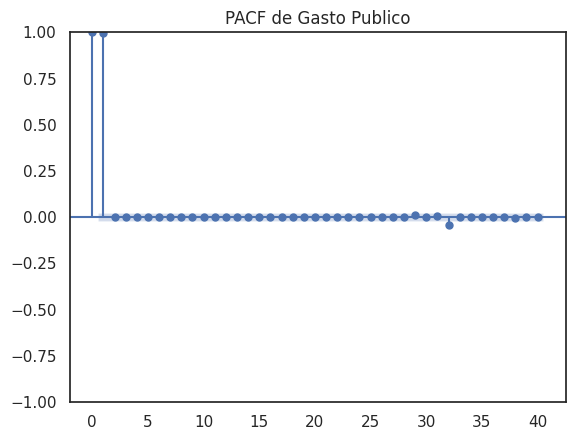

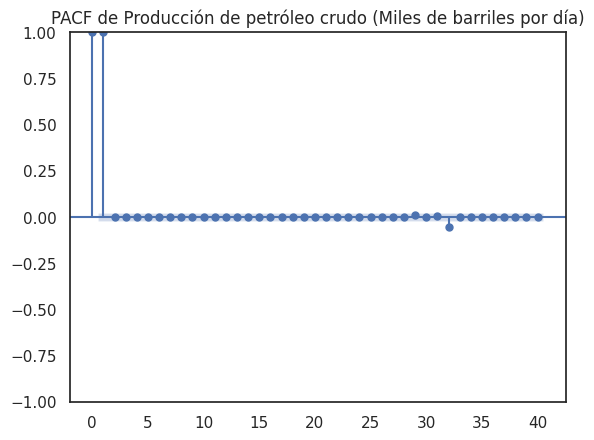

In [ ]:
# 2. Análisis de autocorrelación parcial para selecciona p de forma manual
for col in train_series.columns:
    plot_pacf(train_series[col], lags=40, method='ywm')
    plt.title(f"PACF de {col}")
    plt.show()


# Ajuste y estabilidad del modelo(s) seleccionado(s)

In [ ]:
# Ajuste y estabilidad del modelo VAR
def ajustar_VAR(series_var, p):
    """
    Ajusta un modelo VAR con rezagos `p` y verifica estabilidad.

    Parámetros:
        df (pd.DataFrame): Serie temporal multivariada (preprocesada).
        p (int): Número de rezagos.

    Retorna:
        modelo_fitted (VARResults): Modelo ajustado.
        es_estable (bool): True si el modelo es estable, False en caso contrario.
    """
    modelo = VAR(series_var)
    modelo_fitted = modelo.fit(p)
    es_estable = modelo_fitted.is_stable()

    print(f"🔧 Modelo VAR(p={p}) ajustado.")
    print(f"✅ Estabilidad del modelo: {'Sí' if es_estable else 'No'}")

    return modelo_fitted, es_estable

def graficar_eigenvalores_anotados(modelo_fitted, p, umbral=0.9):
    """
    Grafica los eigenvalores del modelo VAR con anotaciones y resalta los más cercanos al borde.

    Parámetros:
        modelo_fitted (VARResults): Modelo VAR ajustado.
        p (int): Número de rezagos usado en el modelo.
        umbral (float): Umbral para marcar eigenvalores "cercanos al borde".
    """
    # Invertir raíces para usar la convención de estabilidad
    eigenvalores = 1 / modelo_fitted.roots
    modulos = np.abs(eigenvalores)

    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1.5)
    ax.add_artist(circle)

    for i, val in enumerate(eigenvalores):
        color = 'red' if np.abs(val) > umbral else 'blue'
        plt.scatter(val.real, val.imag, color=color, s=70)
        plt.text(val.real + 0.02, val.imag + 0.02, f"{modulos[i]:.2f}", fontsize=9, color=color)

    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.title(f'Modelo VAR(p={p}) - Eigenvalores y módulos (|λ|)', fontsize=13)
    plt.xlabel('Parte real')
    plt.ylabel('Parte imaginaria')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [ ]:
def probar_varios_p_VAR(series_var, lista_p):
    """
    Ajusta modelos VAR para distintos valores de `p`,
    evalúa su estabilidad, grafica eigenvalores y filtra modelos estables.

    Parámetros:
        series_var (pd.DataFrame): Serie temporal multivariada ya preprocesada.
        lista_p (list): Lista de valores de rezago a probar.

    Retorna:
        modelos_dict_filtrados (dict): Solo modelos estables por `p`.
        resumen_df (pd.DataFrame): Estabilidad por `p` para todos los modelos.
    """
    modelos_dict = {}
    resumen_resultados = []

    for p in lista_p:
        try:
            modelo_fitted, es_estable = ajustar_VAR(series_var, p)
            modelos_dict[p] = modelo_fitted
            resumen_resultados.append({'p': p, 'Estable': es_estable})
            graficar_eigenvalores_anotados(modelo_fitted, p)

        except Exception as e:
            print(f"⚠️ Falló el ajuste para p={p}: {str(e)}")
            resumen_resultados.append({'p': p, 'Estable': False})

    # Crear DataFrame de resumen
    resumen_df = pd.DataFrame(resumen_resultados).set_index('p')

    # Filtrar modelos estables automáticamente
    modelos_dict_filtrados = {
        p: modelos_dict[p] for p in resumen_df.index
        if resumen_df.loc[p, 'Estable']
    }

    print(f"\n✅ Modelos estables encontrados: {len(modelos_dict_filtrados)} de {len(lista_p)}")

    return modelos_dict_filtrados, resumen_df


🔧 Modelo VAR(p=2) ajustado.
✅ Estabilidad del modelo: Sí


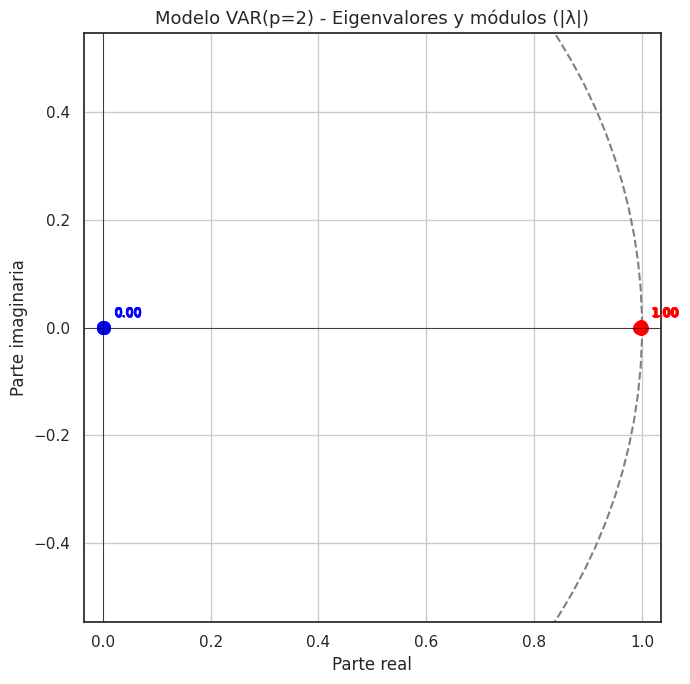

🔧 Modelo VAR(p=3) ajustado.
✅ Estabilidad del modelo: Sí


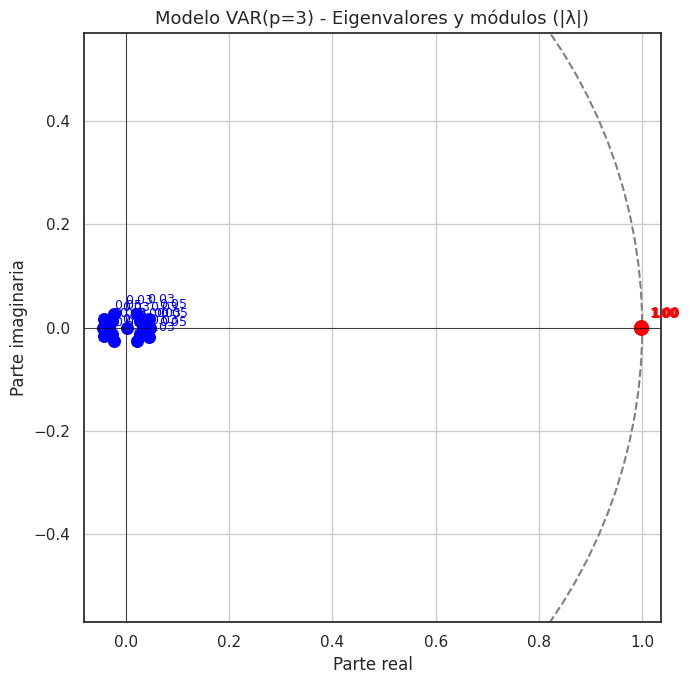

🔧 Modelo VAR(p=5) ajustado.
✅ Estabilidad del modelo: Sí


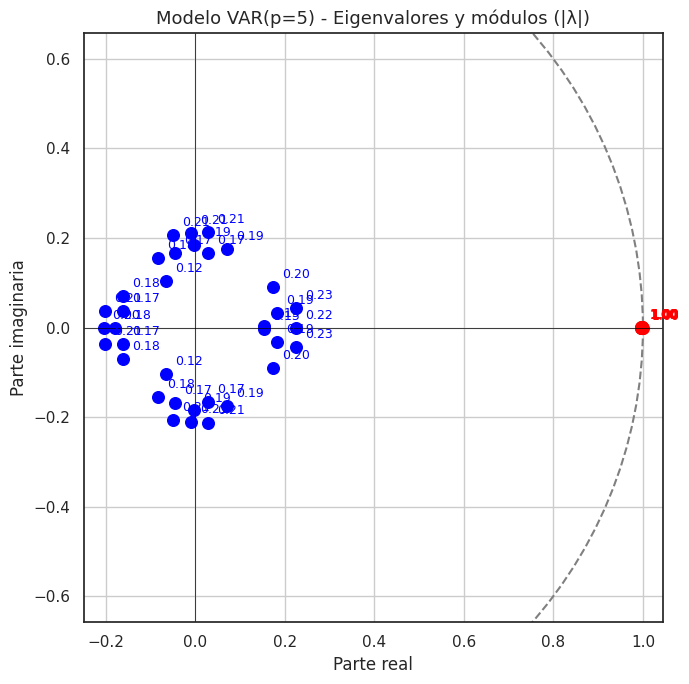


✅ Modelos estables encontrados: 3 de 3
   Estable
p         
2     True
3     True
5     True


In [ ]:
# Lista de rezagos a evaluar
lista_p = [2, 3, 5]

# Ejecutar prueba con múltiples valores de p
modelos_dict, resumen_estabilidad = probar_varios_p_VAR(train_series, lista_p)

# Visualizar resumen
print(resumen_estabilidad)

# Evaluación del modelo

### 🔍 Evaluación de los residuos en un modelo VAR

Evaluar los residuos es una parte crítica para validar la calidad de un modelo VAR. Un buen ajuste debe producir residuos que se comporten como **ruido blanco**, es decir:

- Sin autocorrelación significativa.
- Distribución aproximadamente normal.
- Media cero y varianza constante.

Estas propiedades garantizan que el modelo ha captado correctamente la dinámica de las series temporales. Para ello se aplican las siguientes herramientas:

---

#### 📌 1. Inspección visual de los residuos

Permite observar si los residuos tienen comportamiento aleatorio, o si quedan patrones no explicados. Se observan series individuales, histogramas y densidades.

---

#### 📌 2. Función de autocorrelación (ACF)

Analiza si los residuos están autocorrelacionados en diferentes rezagos. Si aparecen barras significativamente fuera del intervalo de confianza, indica que el modelo no capturó toda la dependencia temporal.

---

#### 📌 3. Prueba estadística de Ljung-Box

Es un contraste formal de hipótesis que evalúa si los residuos están autocorrelacionados en bloque (es decir, en conjunto y no solo en un rezago específico). Si el **p-valor > 0.05**, no se rechaza la hipótesis nula de independencia.

---

> Un modelo VAR con residuos autocorrelacionados puede estar mal especificado: quizás requiere más rezagos o variables adicionales.


In [ ]:
def evaluar_residuos_varios_modelos(modelos_dict, lags=20, lags_ljung=10, mostrar_graficas=True):
    """
    Evalúa y visualiza los residuos de varios modelos VAR.

    Para cada modelo VAR:
        - Muestra residuos, ACF y PACF horizontalmente por variable (opcional).
        - Realiza la prueba de Ljung-Box para cada variable.

    Parámetros:
        modelos_dict (dict): Diccionario con modelos ajustados {p: modelo_fitted}.
        lags (int): Número de rezagos para ACF y PACF (por defecto 20).
        lags_ljung (int): Rezago para prueba de Ljung-Box.
        mostrar_graficas (bool): Si True, muestra gráficos de residuos.

    Retorna:
        df_ljung (pd.DataFrame): Resultados de Ljung-Box por modelo y variable.
    """
    resultados_ljungbox = []

    for p, modelo in modelos_dict.items():
        residuos = modelo.resid
        print(f"\n📊 Evaluación de residuos para modelo VAR(p={p}):")

        for col in residuos.columns:
            if mostrar_graficas:
                fig, axes = plt.subplots(1, 3, figsize=(15, 3))

                # Gráfico de residuos
                axes[0].plot(residuos[col])
                axes[0].set_title(f'Residuos - {col}')
                axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.5)

                # ACF
                plot_acf(residuos[col], lags=lags, ax=axes[1])
                axes[1].set_title('ACF')

                # PACF
                plot_pacf(residuos[col], lags=lags, ax=axes[2], method='ywm')
                axes[2].set_title('PACF')

                plt.suptitle(f'VAR(p={p}) - {col}', fontsize=12)
                plt.tight_layout()
                plt.show()

            # Prueba de Ljung-Box
            ljungbox = acorr_ljungbox(residuos[col], lags=[lags_ljung], return_df=True)
            pval = ljungbox['lb_pvalue'].iloc[0]
            resultados_ljungbox.append({
                'p': p,
                'Variable': col,
                'p-valor': pval,
                'Autocorrelación': 'No' if pval > 0.05 else 'Sí'
            })

    df_ljung = pd.DataFrame(resultados_ljungbox)
    return df_ljung.sort_values(by=["p", "Variable"])


📊 Evaluación de residuos para modelo VAR(p=2):


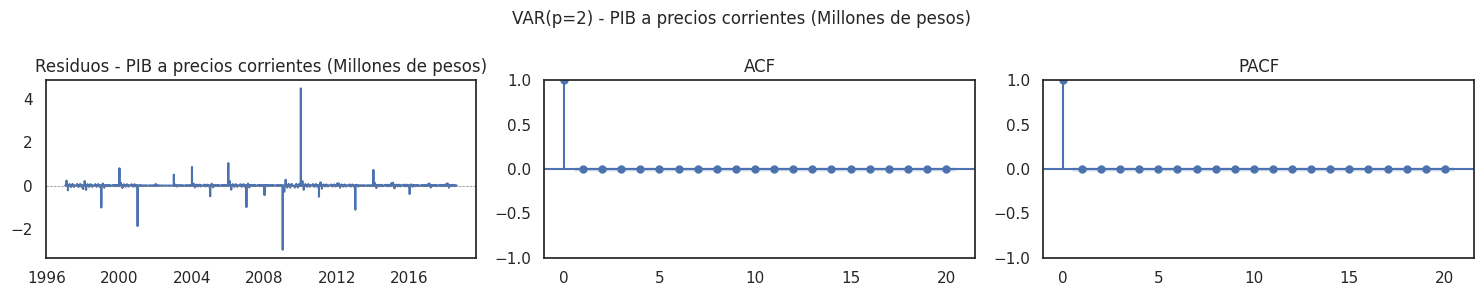

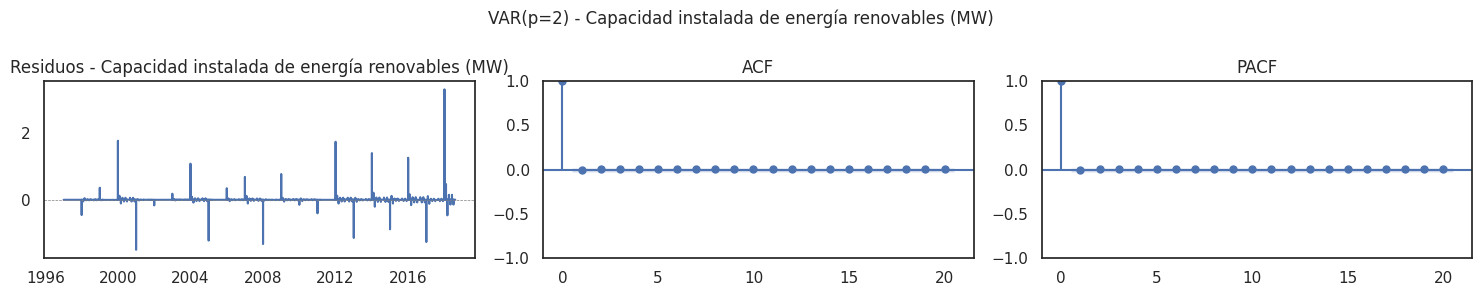

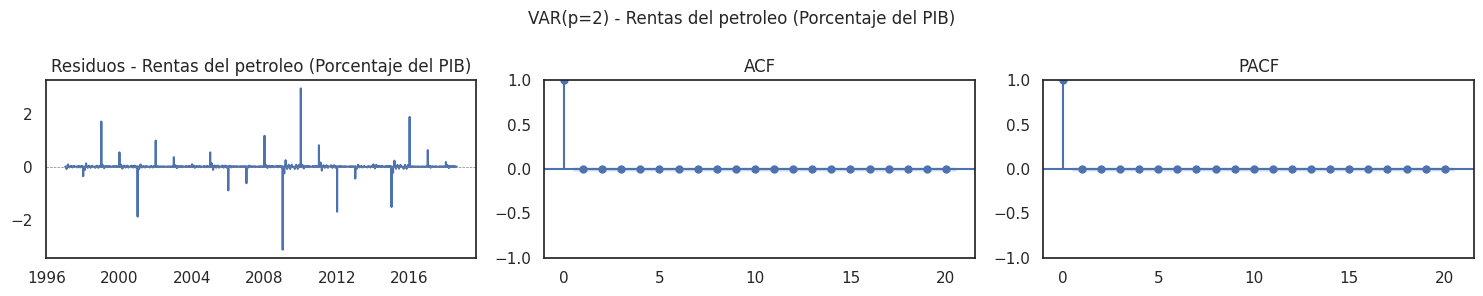

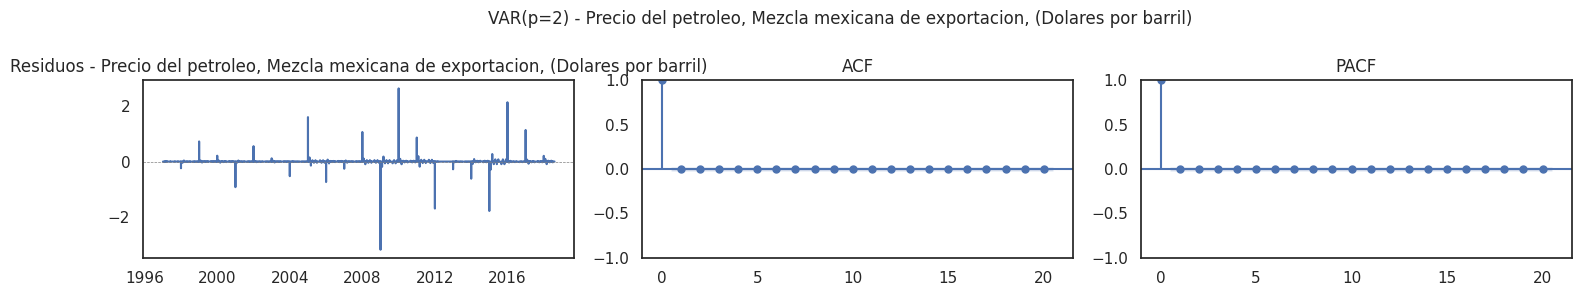

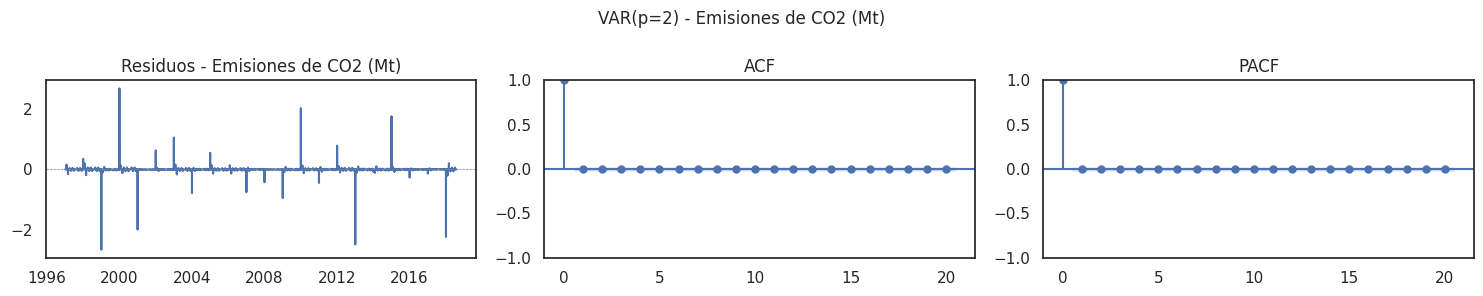

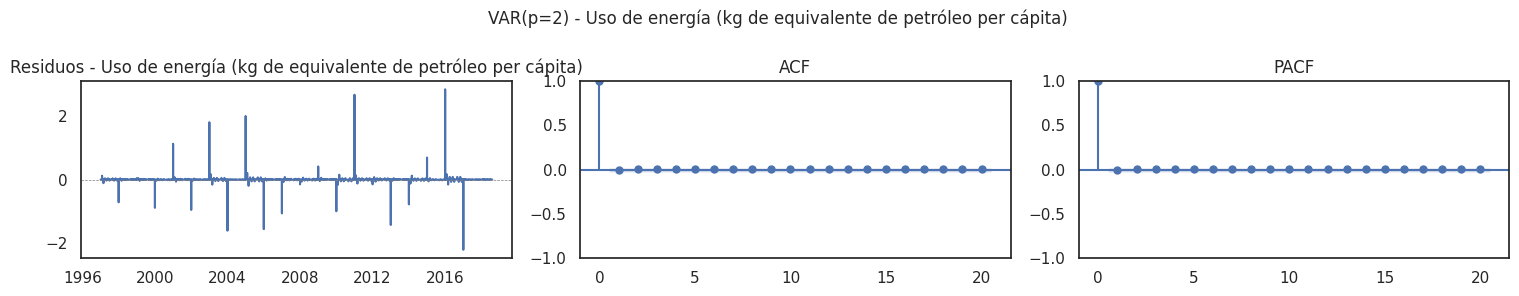

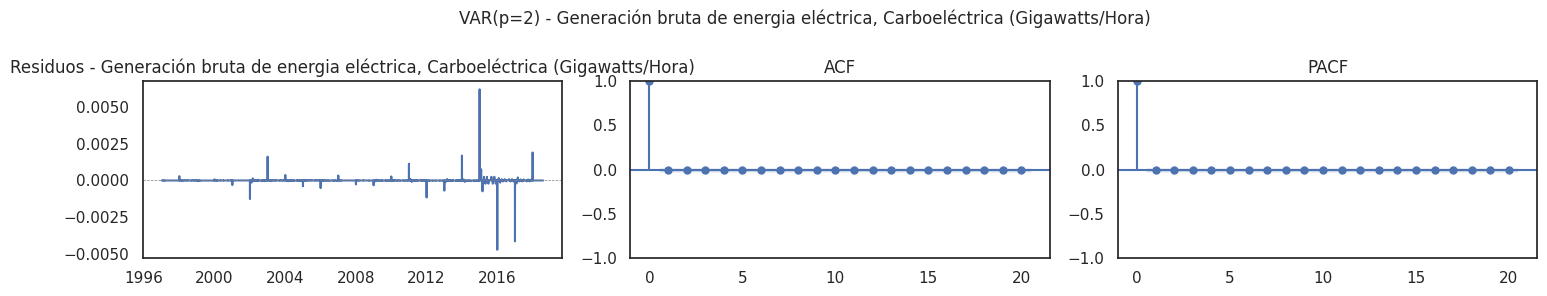

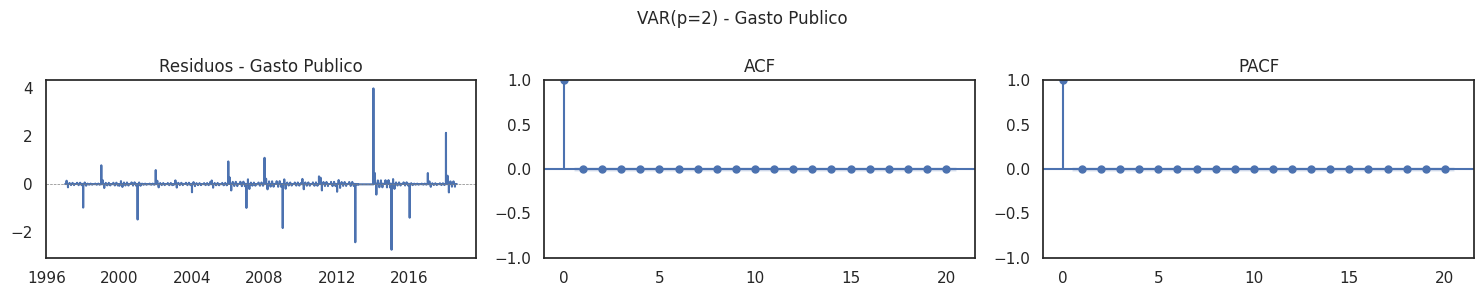

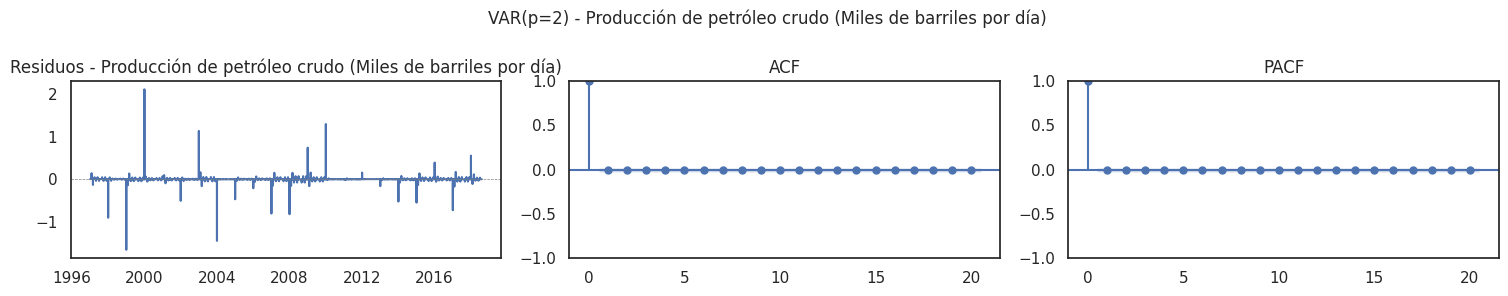


📊 Evaluación de residuos para modelo VAR(p=3):


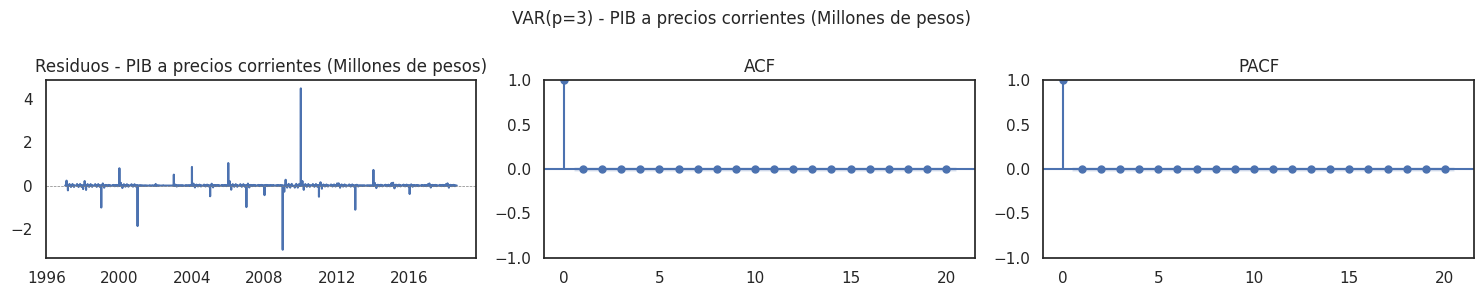

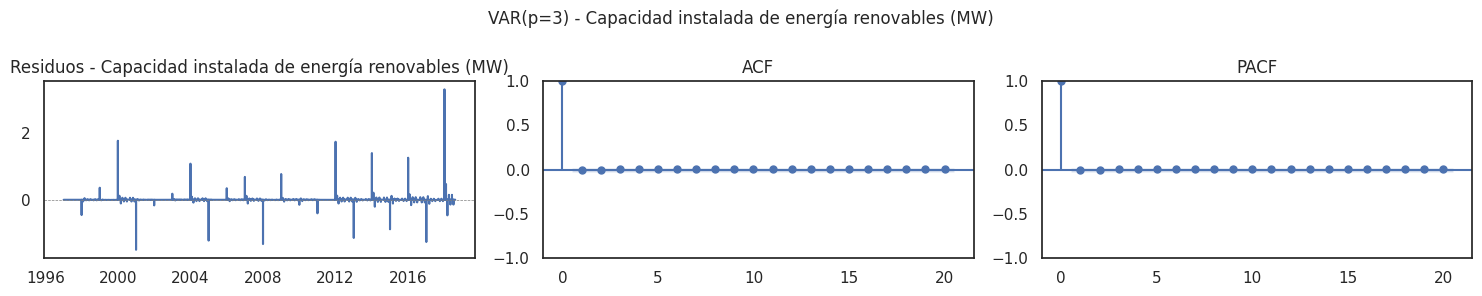

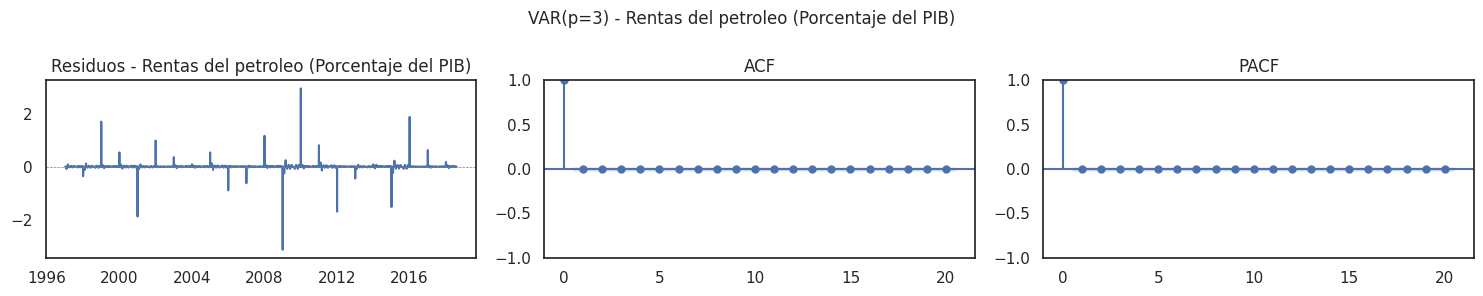

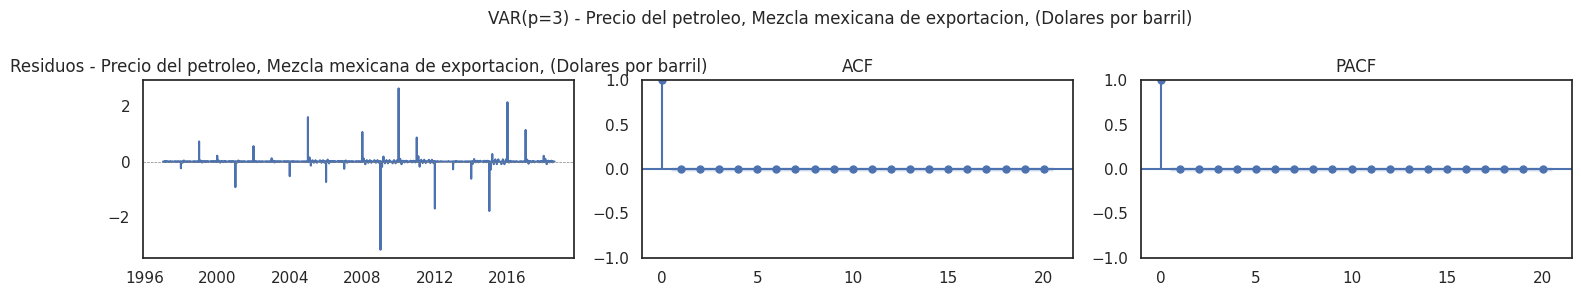

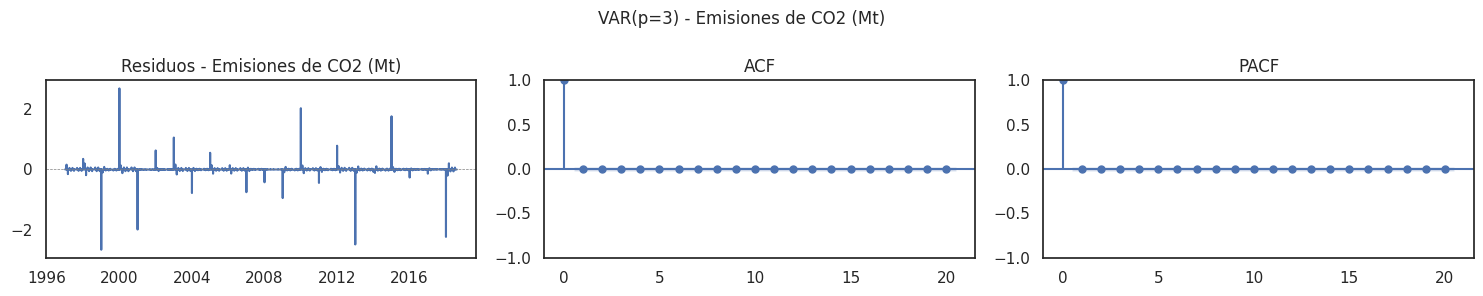

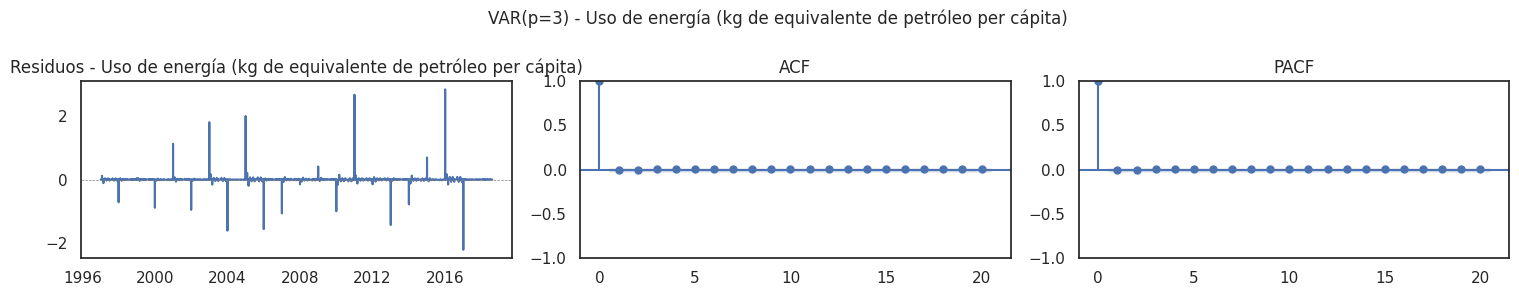

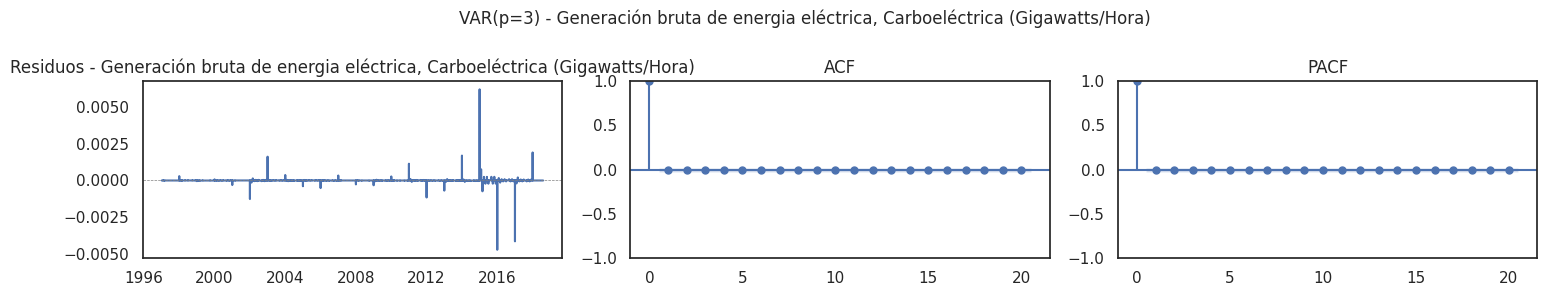

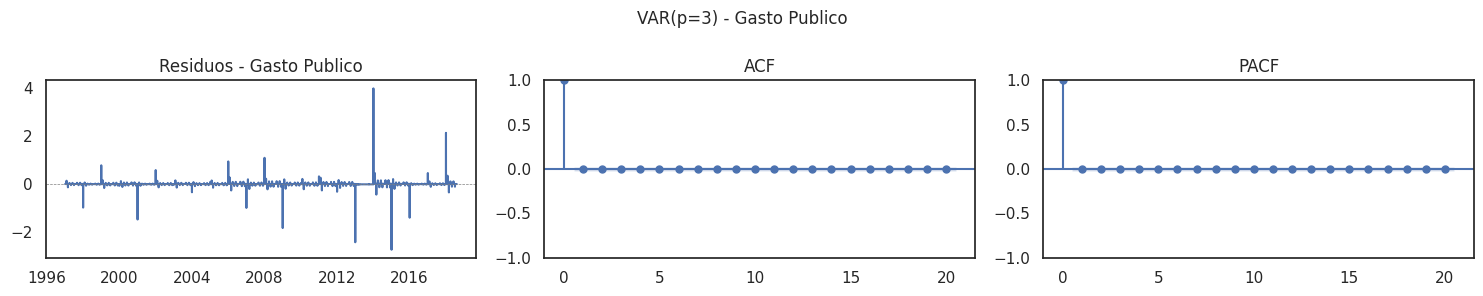

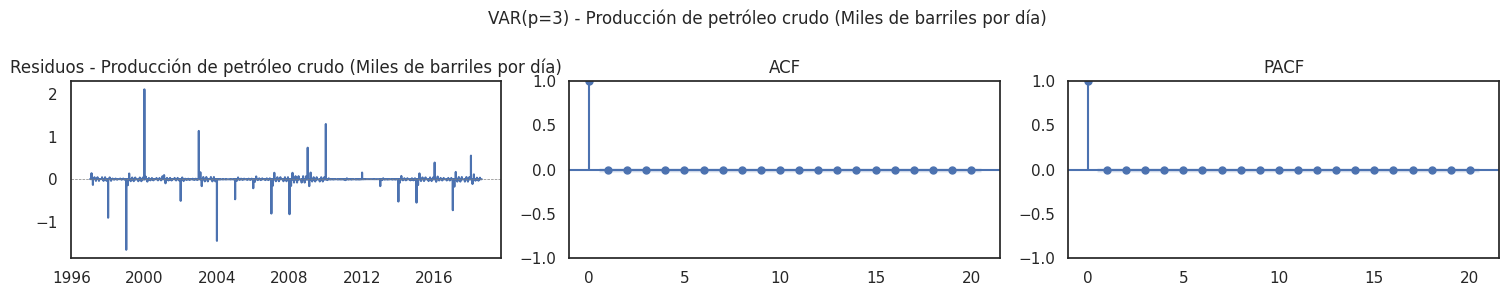


📊 Evaluación de residuos para modelo VAR(p=5):


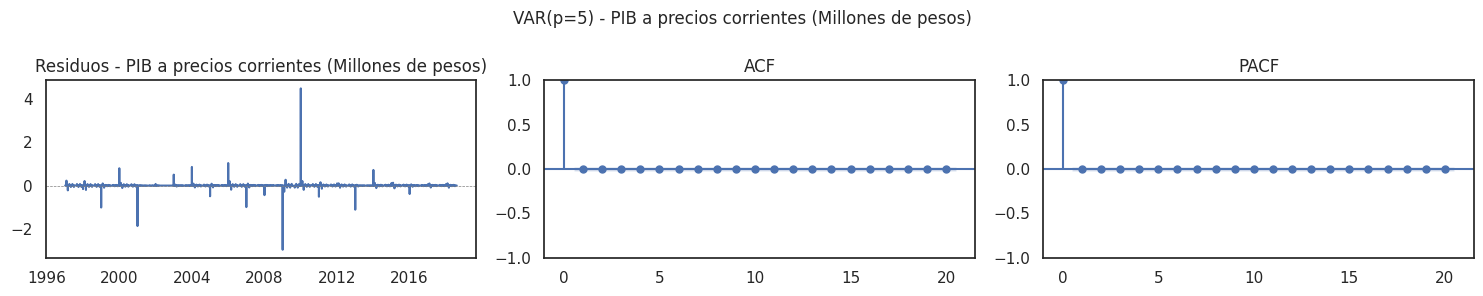

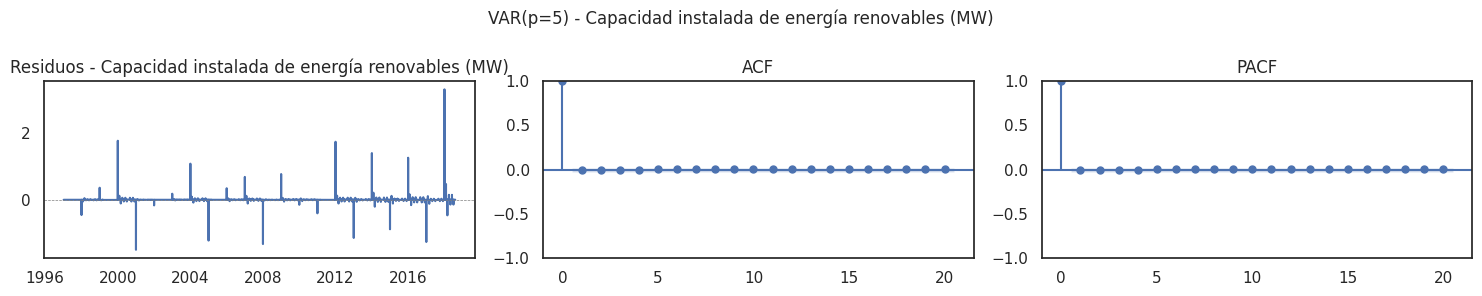

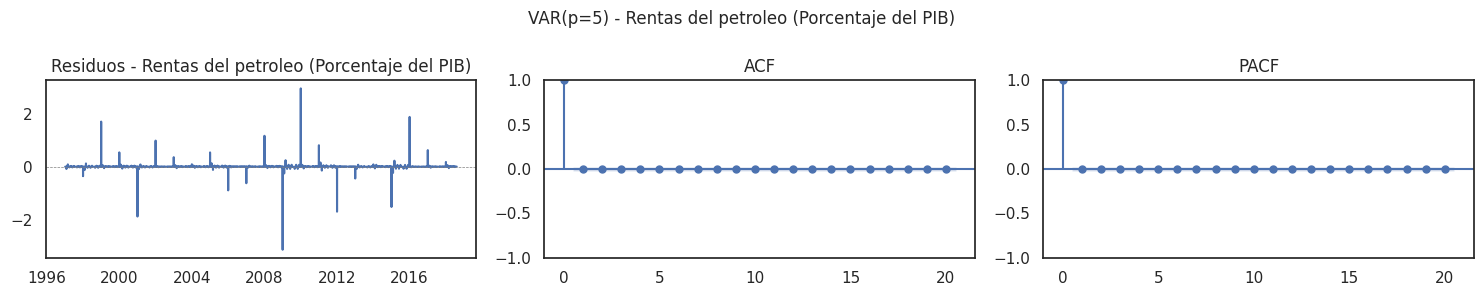

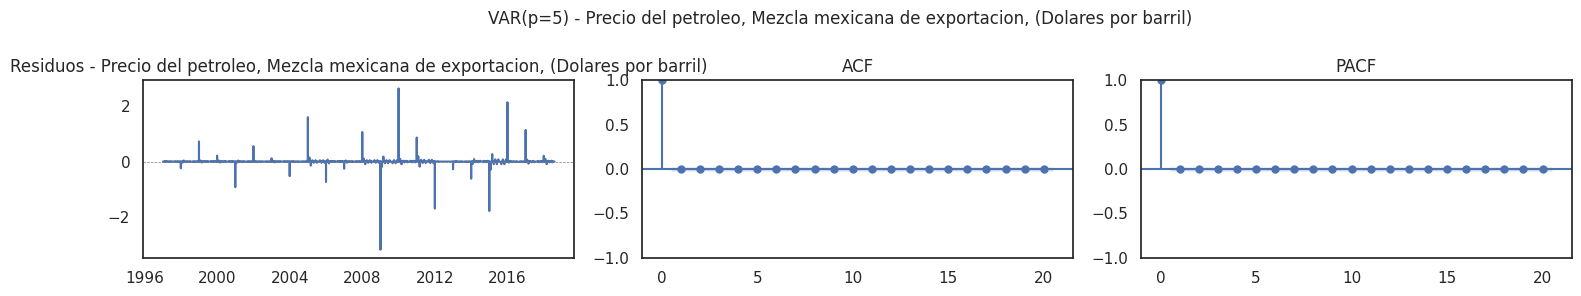

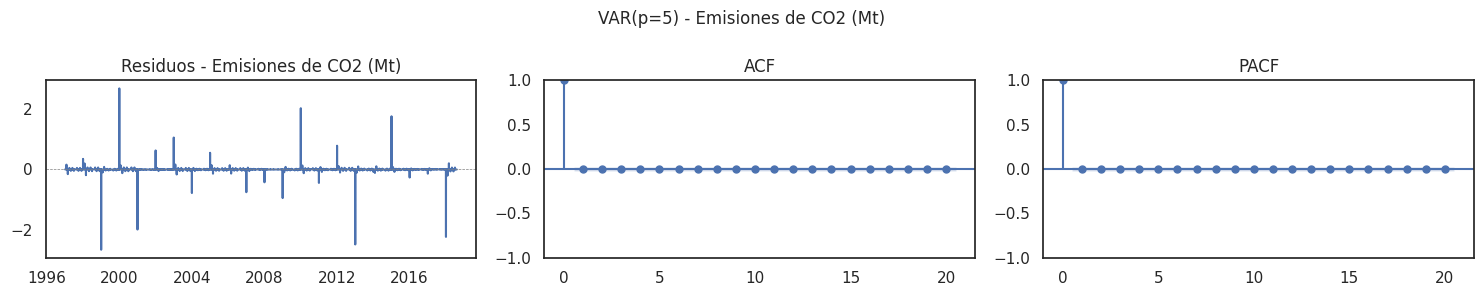

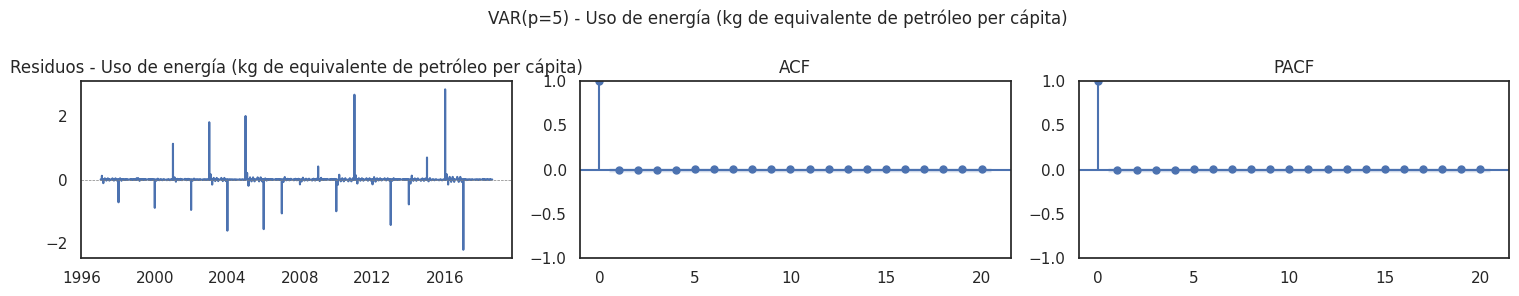

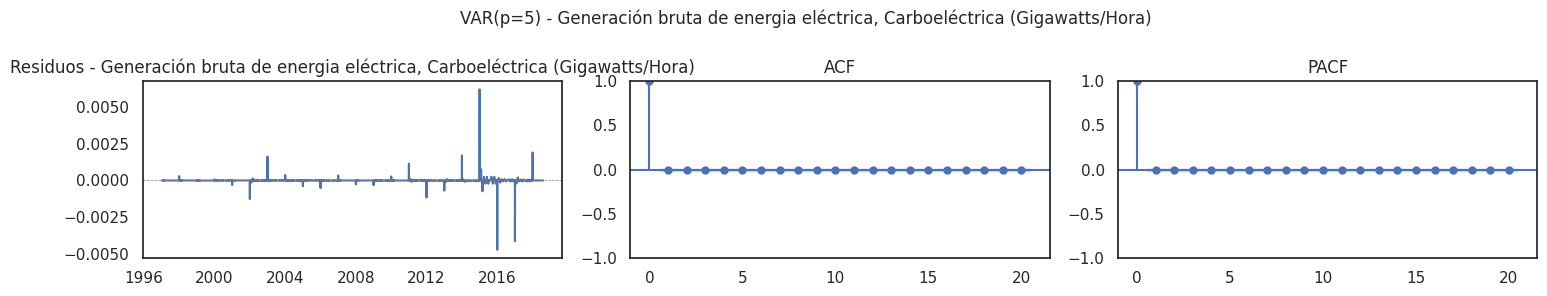

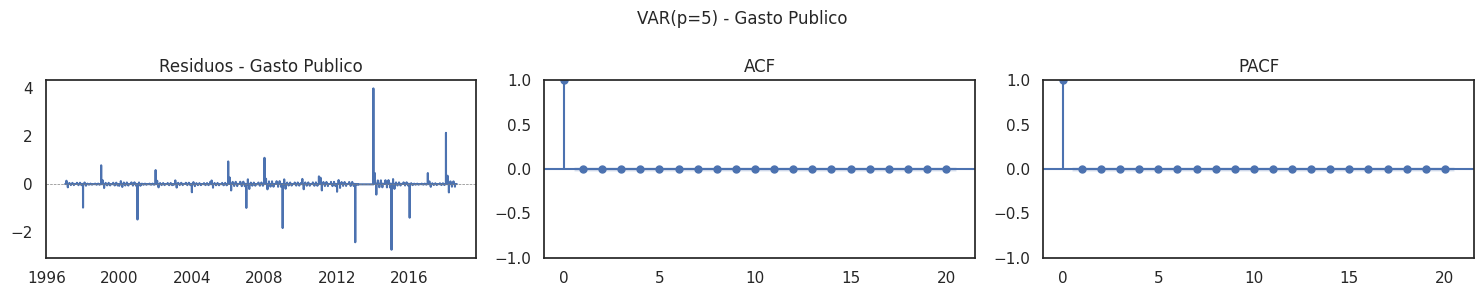

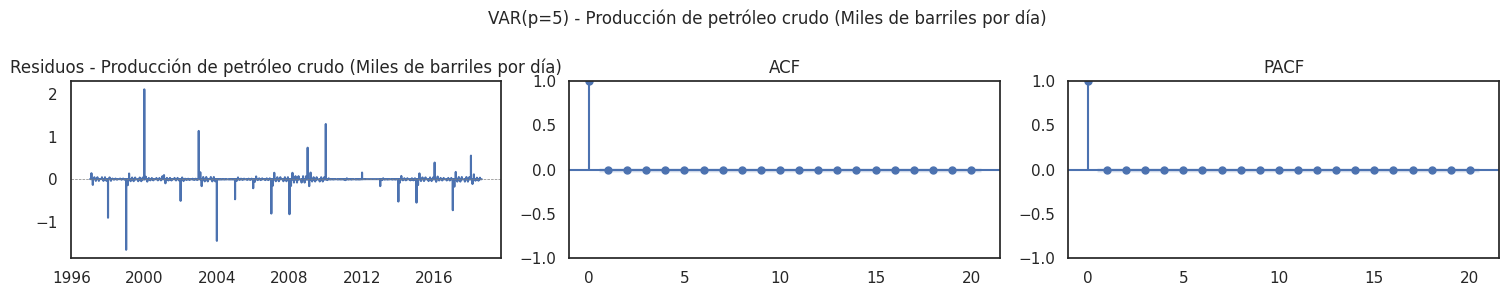

p                                           Variable  p-valor  \
1   2     Capacidad instalada de energía renovables (MW)      1.0   
4   2                              Emisiones de CO2 (Mt)      1.0   
7   2                                      Gasto Publico      1.0   
6   2  Generación bruta de energia eléctrica, Carboel...      1.0   
0   2       PIB a precios corrientes (Millones de pesos)      1.0   
3   2  Precio del petroleo, Mezcla mexicana de export...      1.0   
8   2  Producción de petróleo crudo (Miles de barrile...      1.0   
2   2           Rentas del petroleo (Porcentaje del PIB)      1.0   
5   2  Uso de energía (kg de equivalente de petróleo ...      1.0   
10  3     Capacidad instalada de energía renovables (MW)      1.0   
13  3                              Emisiones de CO2 (Mt)      1.0   
16  3                                      Gasto Publico      1.0   
15  3  Generación bruta de energia eléctrica, Carboel...      1.0   
9   3       PIB a precios corrientes (Millones de pesos)      1.0   
12  3  Precio del petroleo, Mezcla mexicana de export...      1.0   
17  3  Producción de petróleo crudo (Miles de barrile...      1.0   
11  3           Rentas del petroleo (Porcentaje del PIB)      1.0   
14  3  Uso de energía (kg de equivalente de petróleo ...      1.0   
19  5     Capacidad instalada de energía renovables (MW)      1.0   
22  5                              Emisiones de CO2 (Mt)      1.0   
25  5                                      Gasto Publico      1.0   
24  5  Generación bruta de energia eléctrica, Carboel...      1.0   
18  5       PIB a precios corrientes (Millones de pesos)      1.0   
21  5  Precio del petroleo, Mezcla mexicana de export...      1.0   
26  5  Producción de petróleo crudo (Miles de barrile...      1.0   
20  5           Rentas del petroleo (Porcentaje del PIB)      1.0   
23  5  Uso de energía (kg de equivalente de petróleo ...      1.0   

   Autocorrelación  
1               No  
4               No  
7               No  
6               No  
0               No  
3               No  
8               No  
2               No  
5               No  
10              No  
13              No  
16              No  
15              No  
9               No  
12              No  
17              No  
11              No  
14              No  
19              No  
22              No  
25              No  
24              No  
18              No  
21              No  
26              No  
20              No  
23              No

In [ ]:
# --Uso de evaluar_residuos_varios_modelos()
residuos_ljungbox = evaluar_residuos_varios_modelos(modelos_dict, lags=20, lags_ljung=10, mostrar_graficas=True)
display(residuos_ljungbox)

In [ ]:
# Función para resumir los resultados de Ljung-Box por modelo
def resumen_autocorrelacion_por_modelo(df_ljung):
    """
    Resume el porcentaje de variables sin autocorrelación significativa para cada modelo VAR(p).

    Parámetros:
        df_ljung (pd.DataFrame): Resultados de la prueba Ljung-Box por modelo y variable.

    Retorna:
        df_resumen (pd.DataFrame): Porcentaje de variables sin autocorrelación por cada p.
    """
    resumen = df_ljung.groupby('p')['Autocorrelación'].value_counts(normalize=True).unstack().fillna(0)
    resumen = resumen.rename(columns={'No': '% Sin autocorrelación', 'Sí': '% Con autocorrelación'})
    resumen *= 100
    return resumen.round(1)

In [ ]:
# Ejemplo de uso (comentado):
resumen_por_modelo = resumen_autocorrelacion_por_modelo(residuos_ljungbox)
display(resumen_por_modelo)

Autocorrelación  % Sin autocorrelación
p                                     
2                                100.0
3                                100.0
5                                100.0

# Evaluación de las métricas de error tanto en el conjunto de entrenamiento como prueba

In [ ]:
def evaluar_metricas_VAR_train_test(modelos_dict, train_series, test_series, forecast_steps,
                                    variable_objetivo, scaler, series_original):
    """
    Evalúa modelos VAR entrenados sobre series diferenciadas y estandarizadas,
    revirtiendo ambas transformaciones antes de calcular métricas reales en train y test.
    """
    metricas_train = {}
    metricas_test = {}

    for p, modelo in modelos_dict.items():
        try:
            # === Predicción en TRAIN ===
            input_train = train_series.values[-p:]
            pred_train = modelo.forecast(input_train, steps=p)
            pred_df_train = pd.DataFrame(pred_train, columns=train_series.columns)

            pred_train_descaled = pd.DataFrame(scaler.inverse_transform(pred_df_train), columns=train_series.columns)
            ultimo_real_train = series_original[variable_objetivo].iloc[len(train_series) - 1 - p]
            y_pred_train = np.cumsum(pred_train_descaled[variable_objetivo].values) + ultimo_real_train
            y_real_train = series_original[variable_objetivo].iloc[len(train_series) - p : len(train_series)].values

            # Métricas train
            mae_train = mean_absolute_error(y_real_train, y_pred_train)
            rmse_train = np.sqrt(mean_squared_error(y_real_train, y_pred_train))

            # Validar si R2 es computable
            if len(y_real_train) >= 2 and not np.allclose(y_real_train, y_real_train[0]):
                r2_train = r2_score(y_real_train, y_pred_train)
            else:
                print(f"⚠️ Menos de 2 puntos o constante en y_real_train para p={p}: {y_real_train}")
                r2_train = np.nan

            metricas_train[p] = {'MAE': mae_train, 'RMSE': rmse_train, 'R2': r2_train}

            # === Predicción en TEST ===
            input_test = test_series.values[:p]
            pred_test = modelo.forecast(input_test, steps=forecast_steps)
            pred_df_test = pd.DataFrame(pred_test, columns=test_series.columns)

            pred_test_descaled = pd.DataFrame(scaler.inverse_transform(pred_df_test), columns=test_series.columns)
            ultimo_real_test = series_original[variable_objetivo].iloc[len(train_series) - 1]
            y_pred_test = np.cumsum(pred_test_descaled[variable_objetivo].values) + ultimo_real_test
            y_real_test = series_original[variable_objetivo].iloc[len(train_series):len(train_series)+forecast_steps].values

            # Métricas test
            mae_test = mean_absolute_error(y_real_test, y_pred_test)
            rmse_test = np.sqrt(mean_squared_error(y_real_test, y_pred_test))
            r2_test = r2_score(y_real_test, y_pred_test)

            metricas_test[p] = {'MAE': mae_test, 'RMSE': rmse_test, 'R2': r2_test}

        except Exception as e:
            print(f"⚠️ Error en evaluación para p={p}")
            traceback.print_exc()
            metricas_train[p] = {'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan}
            metricas_test[p] = {'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan}

    return metricas_train, metricas_test

In [ ]:
# --Uso de  evaluar_metricas_VAR_train_test
forecast_steps = 30
metricas_train, metricas_test = evaluar_metricas_VAR_train_test(
    modelos_dict=modelos_dict,
    train_series=train_series,
    test_series=test_series,
    forecast_steps=forecast_steps,
    variable_objetivo='Capacidad instalada de energía renovables (MW)',
    scaler=scaler,
    series_original=series_sin_multicolinealidad[['Capacidad instalada de energía renovables (MW)']]  # asegúrate que sea un DataFrame o Series con índice alineado
)

In [ ]:
''' El resultado de la prueba ljung-box sobre los residuos que proporciona la función evaluar_residuos_varios_modelos() es un data frame, hay que CONVERTIR a
    diccionario para que pueda ser usado por la función consolidar_evalauacion_modelos_VAR() '''

def transformar_ljungbox_df_a_dict(df_ljung):
    """
    Convierte un DataFrame de resultados Ljung-Box a un diccionario anidado
    con estructura {p: {variable: {'p-valor': ..., 'autocorrelación': ...}}}
    """
    resultados_dict = {}
    for _, row in df_ljung.iterrows():
        p = row['p']
        var = row['Variable']
        if p not in resultados_dict:
            resultados_dict[p] = {}
        resultados_dict[p][var] = {
            'p-valor': row['p-valor'],
            'autocorrelación': row['Autocorrelación']
        }
    return resultados_dict

In [ ]:
def consolidar_evaluacion_modelos_VAR(resultados_ljungbox, metricas_error_train, metricas_error_test,
                                      variables_objetivo=None, umbral_pvalor=0.05, graficar=True):
    """
    Consolida evaluación de modelos VAR en un solo DataFrame con:
        - % de residuos que pasan Ljung-Box
        - Métricas de error en train y test (MAE, RMSE, R²)
        - Gráficas comparativas (si no hay NaNs)

    Retorna:
        df_resultados (pd.DataFrame): Resumen consolidado por p.
    """
    resumen = []

    for p in metricas_error_test.keys():
        if p not in resultados_ljungbox or p not in metricas_error_train:
            continue

        ljungbox_p = resultados_ljungbox[p]
        variables_validas = variables_objetivo if variables_objetivo else ljungbox_p.keys()
        aceptables = [v for v in variables_validas if ljungbox_p[v]['p-valor'] > umbral_pvalor]
        porcentaje_ruido_blanco = len(aceptables) / len(variables_validas) * 100

        train = metricas_error_train[p]
        test = metricas_error_test[p]

        resumen.append({
            'p': p,
            '% residuos sin autocorrelación (train)': porcentaje_ruido_blanco,
            'MAE (train)': train['MAE'],
            'RMSE (train)': train['RMSE'],
            'R2 (train)': train['R2'],
            'MAE (test)': test['MAE'],
            'RMSE (test)': test['RMSE'],
            'R2 (test)': test['R2']
        })

    df_resultados = pd.DataFrame(resumen).set_index('p')
    df_resultados = df_resultados.sort_values(by='MAE (test)')

    if graficar and not df_resultados.empty:
        # Verificar columnas válidas (sin NaN) para graficar
        col_grupos = [
            ('MAE (train)', 'MAE (test)', "MAE en train y test", "MAE"),
            ('RMSE (train)', 'RMSE (test)', "RMSE en train y test", "RMSE"),
            ('R2 (train)', 'R2 (test)', "R² en train y test", "R²"),
        ]

        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        graficas_plot = 0

        for i, (col_train, col_test, titulo, ylabel) in enumerate(col_grupos):
            if col_train in df_resultados.columns and col_test in df_resultados.columns:
                subset = df_resultados[[col_train, col_test]].dropna()
                if not subset.empty:
                    subset.plot(kind='bar', ax=axes[i // 2, i % 2])
                    axes[i // 2, i % 2].set_title(titulo)
                    axes[i // 2, i % 2].set_ylabel(ylabel)
                    graficas_plot += 1
                else:
                    axes[i // 2, i % 2].set_visible(False)

        # Gráfica de Ljung-Box
        ljung_col = '% residuos sin autocorrelación (train)'
        if ljung_col in df_resultados.columns:
            df_ljung = df_resultados[[ljung_col]].dropna()
            if not df_ljung.empty:
                df_ljung.plot(kind='bar', ax=axes[1, 1], color='green')
                axes[1, 1].set_title(ljung_col)
                axes[1, 1].set_ylabel("%")
                graficas_plot += 1
            else:
                axes[1, 1].set_visible(False)

        if graficas_plot > 0:
            plt.suptitle("Evaluación comparativa de modelos VAR", fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No hay métricas suficientes para graficar comparaciones.")

    return df_resultados


In [ ]:
# Transformación de data frame a diccionario de la prueba ljung-box sobre los residuos
resultados_ljungbox = transformar_ljungbox_df_a_dict(residuos_ljungbox)

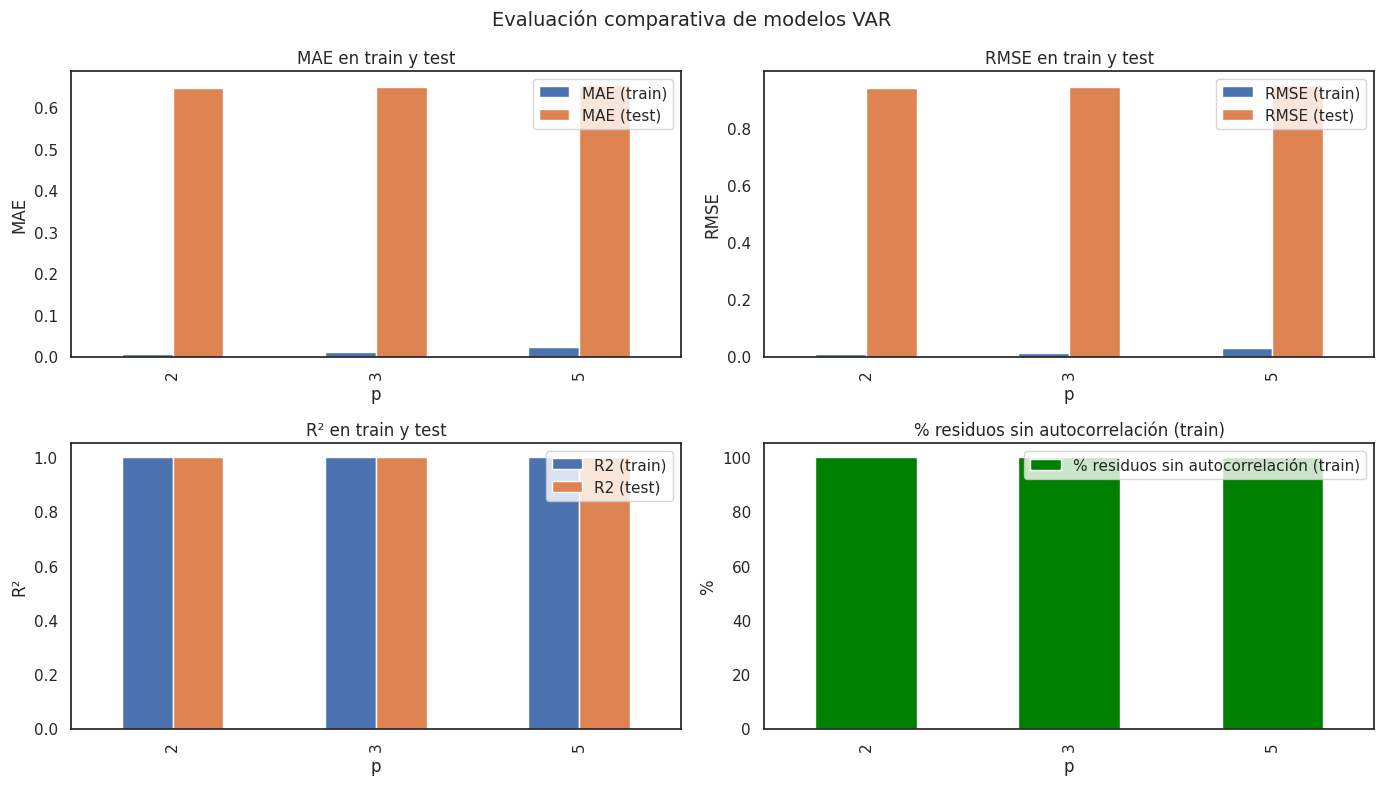

In [ ]:
# -- Uso de consolidar_evaluacion_modelos_VAR()
df_resultados = consolidar_evaluacion_modelos_VAR(
    resultados_ljungbox=resultados_ljungbox,
    metricas_error_train=metricas_train,
    metricas_error_test=metricas_test,
    variables_objetivo=['Capacidad instalada de energía renovables (MW)'],  # opcional
    umbral_pvalor=0.05,
    graficar=True
)

In [ ]:
df_resultados

% residuos sin autocorrelación (train)  MAE (train)  RMSE (train)  \
p                                                                      
2                                   100.0     0.006750      0.007547   
3                                   100.0     0.011297      0.013269   
5                                   100.0     0.023918      0.029425   

   R2 (train)  MAE (test)  RMSE (test)  R2 (test)  
p                                                  
2    0.999997    0.646408     0.940368   0.999839  
3    0.999996    0.648799     0.943436   0.999838  
5    0.999994    0.653627     0.949634   0.999836

# Predicción en conjunto de entrenamiento y prueba

#### ✅ 1. Reversión de transformaciones

Dado que las series fueron:
- Diferenciadas (para estacionariedad), y
- Estandarizadas (para homogeneidad),

es necesario **revertir estas transformaciones** para obtener los valores finales en la escala original:

- **Desestandarización**: aplicar `.inverse_transform()` del `StandardScaler`.
- **Reversión de diferencia**: sumar las predicciones acumuladas al último valor original conocido (antes de la diferencia).

---

#### ⚠️ Importante

Este proceso es sensible a errores acumulados, ya que cada predicción se basa en las anteriores. Por lo tanto, se recomienda comparar visualmente las predicciones con los valores reales, si están disponibles.

---


In [ ]:
def graficar_VAR_train_test(modelos_dict, train_series, test_series, series_original,
                             scaler, variable_objetivo, guardar_predicciones=False):
    """
    Visualiza la serie real completa, predicción in-sample (entrenamiento) y predicción sobre el conjunto de prueba
    (out-sample) comparada con los valores reales. No realiza forecast futuro.

    Parámetros:
        modelos_dict (dict): Modelos VAR entrenados {p: modelo_fitted}.
        train_series (pd.DataFrame): Conjunto de entrenamiento (diferenciado + estandarizado).
        test_series (pd.DataFrame): Conjunto de prueba (diferenciado + estandarizado).
        series_original (pd.DataFrame): Serie original sin transformar.
        scaler (StandardScaler): Escalador ajustado solo con train.
        variable_objetivo (str): Nombre de la variable objetivo.
        guardar_predicciones (bool): Si True, retorna las predicciones del conjunto de prueba por modelo.

    Retorna:
        pd.DataFrame con predicciones si guardar_predicciones=True.
    """
    forecast_steps = len(test_series)
    y_real = series_original[variable_objetivo]
    predicciones_test_dict = {}

    plt.figure(figsize=(14, 6))
    plt.plot(y_real.index, y_real.values, label='Serie real', color='black', linewidth=2)

    for p, modelo in modelos_dict.items():
        try:
            # === In-sample ===
            fitted_values = modelo.fittedvalues
            fitted_desescalado = scaler.inverse_transform(fitted_values)
            y_insample = np.cumsum(fitted_desescalado[:, train_series.columns.get_loc(variable_objetivo)]) + \
                         series_original[variable_objetivo].iloc[p - 1]
            fechas_insample = series_original.index[p:len(y_insample) + p]
            plt.plot(fechas_insample, y_insample, label=f'In-sample VAR(p={p})', linestyle='--')

            # === Predicción sobre test ===
            input_test = test_series.values[:p]
            forecast_test = modelo.forecast(input_test, steps=forecast_steps)
            forecast_df = pd.DataFrame(forecast_test, columns=test_series.columns)
            forecast_desescalado = scaler.inverse_transform(forecast_df)

            y0 = series_original[variable_objetivo].iloc[len(train_series) - 1]
            y_pred_test = np.cumsum(forecast_desescalado[:, test_series.columns.get_loc(variable_objetivo)]) + y0

            fechas_test = series_original.index[len(train_series):len(train_series) + forecast_steps]
            plt.plot(fechas_test, y_pred_test, label=f'Test VAR(p={p})', linestyle=':', color = 'orange')

            if guardar_predicciones:
                predicciones_test_dict[f'VAR(p={p})'] = y_pred_test

        except Exception as e:
            print(f"⚠️ Error al graficar modelo p={p}: {e}")

    plt.title(f"Serie real vs. predicción in-sample y en conjunto de prueba ({variable_objetivo})")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if guardar_predicciones:
        return pd.DataFrame(predicciones_test_dict, index=fechas_test).rename_axis("Fecha")



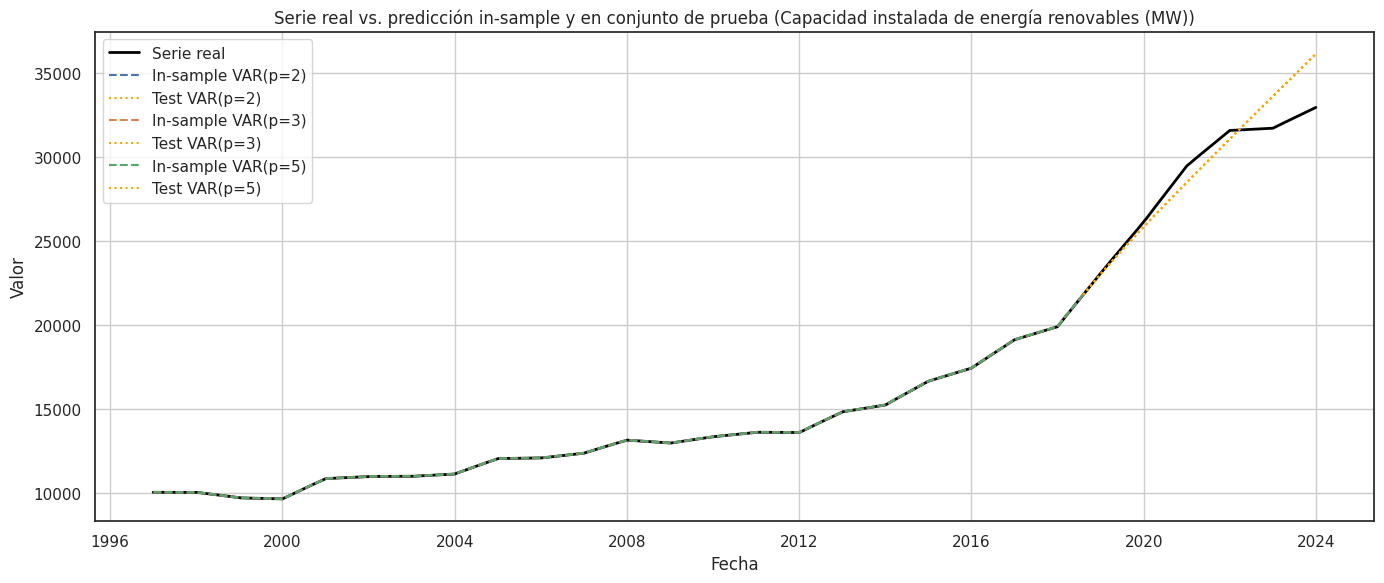

In [ ]:
# --Uso de graficar_VAR_train_test
df_predicciones_test = graficar_VAR_train_test(
    modelos_dict=modelos_dict,
    train_series=train_series,
    test_series=test_series,
    series_original=series_sin_multicolinealidad,
    scaler=scaler,
    variable_objetivo='Capacidad instalada de energía renovables (MW)',
    guardar_predicciones=True  # Si deseas también guardar las predicciones en un DataFrame
)


In [ ]:
# Guardar como .xlsx las predicciones del modelo VAR sobre el conjunto de prueba
nombre_archivo = "forecast_CIER_VAR_test.xlsx"
df_predicciones_test.to_excel(ruta + nombre_archivo)

In [ ]:
df_predicciones_test.head()

VAR(p=2)      VAR(p=3)      VAR(p=5)
Fecha                                               
2018-08-06  21795.889098  21795.889083  21795.889053
2018-08-07  21804.419986  21804.419942  21804.419854
2018-08-08  21812.947511  21812.947423  21812.947246
2018-08-09  21821.471676  21821.471530  21821.471234
2018-08-10  21829.992488  21829.992268  21829.991825

## 📌 Conclusión: Modelo VAR como base explicativa y predictiva

El modelo **VAR (Vector Autoregressivo)** es una herramienta poderosa para analizar relaciones dinámicas entre múltiples series temporales. A través de mecanismos como:

- **IRF (Impulse Response Function)** y
- **FEVD (Forecast Error Variance Decomposition)**,

el VAR permite evaluar cómo los shocks en una variable se propagan hacia otras, ayudando a comprender la estructura causal y de retroalimentación del sistema.

Sin embargo, al estar limitado a supuestos lineales y requerir estacionariedad, su capacidad predictiva puede verse comprometida ante dinámicas complejas o no lineales. En estos casos, es conveniente **complementar el modelo VAR con técnicas de aprendizaje profundo** como LSTM o Transformers, que destacan por su flexibilidad para modelar patrones no lineales y dependencias de largo plazo.

👉 Por tanto, una estrategia híbrida basada en VAR + LSTM/Transformer permite:
- **Explicabilidad estructural** mediante VAR.
- **Predicción precisa** mediante modelos de deep learning.

Esto brinda una base robusta para el análisis y pronóstico de sistemas económicos multivariados.


# Filtro para elegir el mejor modelo

📐 MAE – Error Absoluto Medio

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

- Penaliza errores grandes: ❌ No
- Robusta frente a outliers: ✅ Sí
- Interpretación: Promedio del tamaño del error absoluto
- Uso recomendado: Cuando se busca una medida robusta y directa del error medio


📐 RMSE – Raíz del Error Cuadrático Medio

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

- Penaliza errores grandes: ✅ Sí
- Robusta frente a outliers: ❌ No
- Interpretación: Error promedio ponderando más los errores grandes
- Uso recomendado: Cuando los errores grandes deben evitarse a toda costa

📐 R² – Coeficiente de determinación

$$
R^2 = 1 - \frac{ \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n}(y_i - \bar{y})^2 }
$$

- Penaliza errores grandes: ❌ No directamente
- Robusta frente a outliers: ⚠️ Depende de los datos
- Interpretación: Proporción de la varianza explicada por el modelo
- Uso recomendado: Para evaluar la capacidad global de explicación del modelo

In [ ]:
def seleccionar_mejor_modelo_VAR(df_resultados, metrica_prioridad='MAE (test)', modo='min',
                                 ponderacion=None, metrica_deseable=None,
                                 umbral_autocorrelacion=90.0,
                                 verbose=True, graficar_radar=True,
                                 guardar_csv=False, ruta_csv='modelos_VAR_ordenados.csv'):
    """
    Selecciona el mejor modelo VAR considerando:
        - Ponderación multi-métrica (sin pesos negativos).
        - Filtro por autocorrelación en residuos (Ljung-Box).
        - Radar plot de comparación (opcional).

    Parámetros:
        df_resultados (pd.DataFrame): Resultados consolidados por modelo VAR (índice: p).
        metrica_prioridad (str): Métrica base si no se usa ponderación.
        modo (str): 'min' o 'max' para la métrica_prioridad.
        ponderacion (dict): {métrica: peso positivo}.
        metrica_deseable (dict): {métrica: 'min' o 'max'} para normalización.
        umbral_autocorrelacion (float): % mínimo de residuos sin autocorrelación para aceptar un modelo.
        verbose (bool): Mostrar mejor modelo y top resultados.
        graficar_radar (bool): Mostrar radar de comparación.
        guardar_csv (bool): Guardar DataFrame ordenado.
        ruta_csv (str): Ruta para guardar archivo CSV.

    Retorna:
        mejor_p (int): Orden p del mejor modelo.
        df_ordenado (pd.DataFrame): DataFrame ordenado.
    """
    df = df_resultados.copy()

    # === Filtro por autocorrelación de residuos
    if '% residuos sin autocorrelación (train)' not in df.columns:
        raise ValueError("La columna '% residuos sin autocorrelación (train)' es obligatoria.")

    df_filtrado = df[df['% residuos sin autocorrelación (train)'] >= umbral_autocorrelacion].copy()

    if df_filtrado.empty:
        print(f"⚠️ Ningún modelo pasó el umbral de autocorrelación ({umbral_autocorrelacion}%). Se usarán todos los modelos.")
        df_filtrado = df.copy()

    if ponderacion:
        if metrica_deseable is None:
            raise ValueError("Debes proporcionar el diccionario metrica_deseable junto con la ponderación.")

        puntajes = []
        for metrica, peso in ponderacion.items():
            if metrica not in df_filtrado.columns:
                raise ValueError(f"La métrica '{metrica}' no está en df_resultados.")
            if metrica not in metrica_deseable:
                raise ValueError(f"Debes indicar si '{metrica}' se desea 'min' o 'max' en metrica_deseable.")

            sentido = metrica_deseable[metrica]
            col = df_filtrado[metrica]

            col_norm = (col - col.min()) / (col.max() - col.min() + 1e-9)
            col_norm = col_norm.fillna(0.5)

            if sentido == 'min':
                col_norm = 1 - col_norm

            puntajes.append(col_norm * peso)

        df_filtrado['Puntaje_total'] = sum(puntajes)
        df_ordenado = df_filtrado.sort_values(by='Puntaje_total', ascending=False)
    else:
        ascending = modo == 'min'
        df_ordenado = df_filtrado.sort_values(by=metrica_prioridad, ascending=ascending)

    mejor_p = df_ordenado.index[0]

    if guardar_csv:
        df_ordenado.to_csv(ruta_csv)

    if verbose:
        print(f"✅ Mejor modelo: p = {mejor_p}")
        display(df_ordenado.head())

    if graficar_radar and ponderacion:
        etiquetas = list(ponderacion.keys())
        num_vars = len(etiquetas)
        angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angulos += angulos[:1]

        fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(polar=True))
        cmap = plt.get_cmap("tab10")

        for i, (p, fila) in enumerate(df_ordenado.iterrows()):
            valores = []
            for metrica in etiquetas:
                col = df_filtrado[metrica]
                col_norm = (col - col.min()) / (col.max() - col.min() + 1e-9)
                col_norm = col_norm.fillna(0.5)

                val_norm = col_norm.loc[p]
                if metrica_deseable[metrica] == 'min':
                    val_norm = 1 - val_norm
                valores.append(val_norm)
            valores += valores[:1]
            ax.plot(angulos, valores, label=f'p={p}', color=cmap(i))
            ax.fill(angulos, valores, alpha=0.1, color=cmap(i))

        ax.set_xticks(angulos[:-1])
        ax.set_xticklabels(etiquetas, fontsize=10)
        ax.set_title("Comparación normalizada de modelos VAR", fontsize=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        plt.tight_layout()
        plt.show()

    return mejor_p, df_ordenado


✅ Mejor modelo: p = 2


% residuos sin autocorrelación (train)  MAE (train)  RMSE (train)  \
p                                                                      
2                                   100.0     0.006750      0.007547   
3                                   100.0     0.011297      0.013269   
5                                   100.0     0.023918      0.029425   

   R2 (train)  MAE (test)  RMSE (test)  R2 (test)  Puntaje_total  
p                                                                 
2    0.999997    0.646408     0.940368   0.999839   9.999687e-01  
3    0.999996    0.648799     0.943436   0.999838   6.689236e-01  
5    0.999994    0.653627     0.949634   0.999836   1.154869e-07

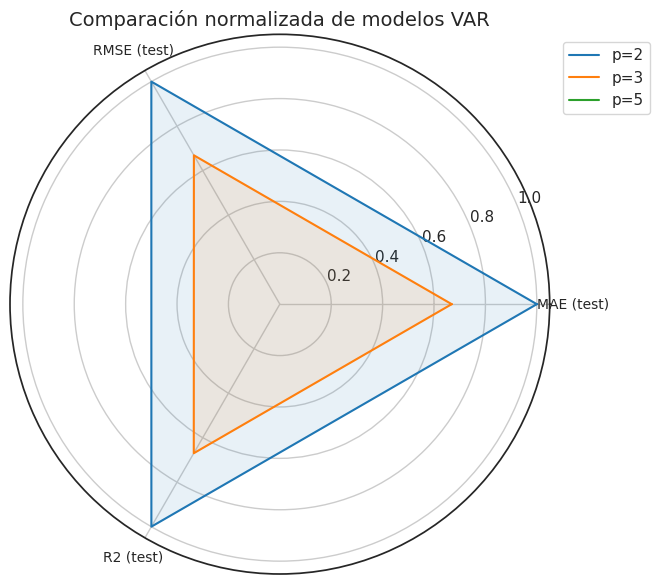

In [ ]:
ponderacion = {
    'MAE (test)': 0.6,
    'RMSE (test)': 0.3,
    'R2 (test)': 0.1,
}

metrica_deseable = {
    'MAE (test)': 'min',
    'RMSE (test)': 'min',
    'R2 (test)': 'max',
}

mejor_p, df_ordenado = seleccionar_mejor_modelo_VAR(
    df_resultados=df_resultados,
    ponderacion=ponderacion,
    metrica_deseable=metrica_deseable,
    umbral_autocorrelacion=95.0,  # ⚠️ filtro clave
    graficar_radar=True,
    guardar_csv=True,
    ruta_csv=ruta + 'mejores_modelos_VAR_filtrados.csv'
)

# Causalidad de Granger
### ¿Qué es la causalidad de Granger?

La causalidad de Granger no implica una relación causal “real”, sino **predictiva**.  
Decimos que una variable **X Granger-causa a Y** si los valores pasados de X contienen información que mejora la predicción de Y más allá de lo que aportan los propios rezagos de Y.  

- **p-valor bajo (< 0.05):** X ayuda a predecir a Y → se rechaza la hipótesis nula de “no causalidad de Granger”.  
- **p-valor alto (> 0.05):** X no aporta información adicional → no hay evidencia de causalidad de Granger.  

En resumen: Granger mide si una serie **tiene poder predictivo** sobre otra dentro del marco temporal analizado.



In [ ]:
# Function to run Granger causality for all pairs
def granger_causality_matrix(series_var, maxlag=mejor_p, guardar=True):
    """
    Run pairwise Granger causality tests across all variables.
    Returns DataFrame with min p-values for each (cause → effect).
    """
    variables = series_var.columns
    results = pd.DataFrame(np.zeros((len(variables), len(variables))),
                           columns=variables, index=variables)

    for c in variables:
        for r in variables:
            if c != r:
                test_result = grangercausalitytests(series_var[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test[0]['ssr_chi2test'][1],4) for test in test_result.values()]
                results.loc[r, c] = np.min(p_values)  # min p-value across lags
    if guardar:
      results.to_csv(ruta + 'resultados_granger.csv')
    return results


In [ ]:
gc_matrix = granger_causality_matrix(series_var, maxlag=mejor_p)
print(type(gc_matrix))

<class 'pandas.core.frame.DataFrame'>


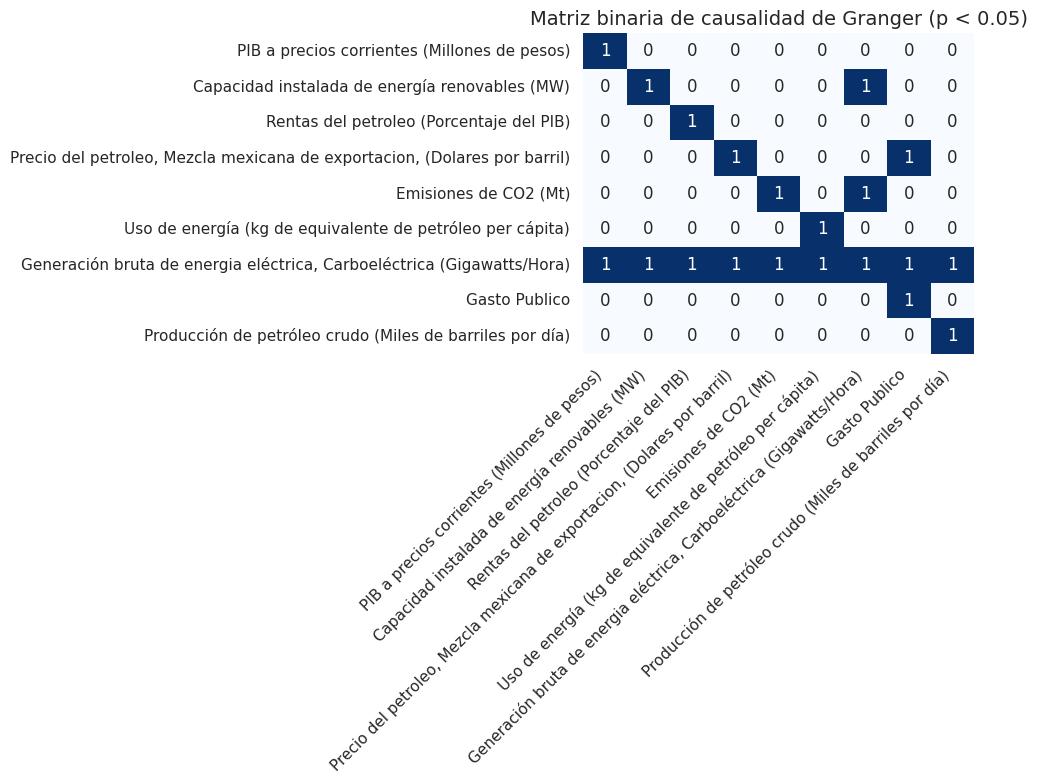

In [ ]:
# Visualización de las causalidades de granger (filtradas entre existe causalidad = 1 y no causalidad = 0 )
alpha = 0.05
gc_binary = (gc_matrix < alpha).astype(int)

# Heatmap binario
plt.figure(figsize=(10,8))
sns.heatmap(gc_binary, annot=True, cmap="Blues", cbar=False, fmt="d")

plt.title("Matriz binaria de causalidad de Granger (p < 0.05)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


🔹 **Cómo interpretar la matriz de causalidad de Granger**

- La **fila** representa la **variable efecto (dependiente)**.  
- La **columna** representa la **variable causa (independiente)**.  
- Cada celda indica si los rezagos de la columna ayudan a predecir la fila:  
  - **1 (p < 0.05):** la variable en la columna **Granger-causa** a la variable en la fila.  
  - **0 (p ≥ 0.05):** no hay evidencia de que la columna mejore la predicción de la fila.  

📌 Recuerda:  
- La causalidad de Granger es **predictiva, no causalidad estructural real**.  
- Lo ideal es complementar con:
  - **Granger →** “¿Quién predice a quién?”  
  - **IRF →** “¿Qué pasa dinámicamente tras un shock?”  
  - **FEVD →** “¿Quién explica más varianza a largo plazo?”  

---

✅ **Ejemplo de interpretación**

Si en la fila **PIB** y la columna **Precio del petróleo** aparece un **1**:  
- Significa que los rezagos del **precio del petróleo** ayudan a predecir al **PIB**.  
- En notación: *Precio del petróleo → PIB* (causa → efecto).  

En cambio, si en esa misma celda hubiera un **0**:  
- No habría evidencia estadística de que el precio del petróleo mejore la predicción del PIB.


In [ ]:
# Selección de PARES más RELEVANTES

# --- Opcional: nombres cortos para el paper ---
rename_map = {
    "PIB a precios corrientes (Millones de pesos)": "PIB",
    "Capacidad instalada de energía renovables (MW)": "Renovables",
    "Rentas del petroleo (Porcentaje del PIB)": "RentasPet",
    "Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril)": "PrecioPet",
    "Emisiones de CO2 (Mt)": "CO2",
    "Uso de energía (kg de equivalente de petróleo per cápita)": "UsoEnergia",
    "Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora)": "CarboElect",
    "Gasto Publico": "GastoPub",
    "Producción de petróleo crudo (Miles de barriles por día)": "ProdPet",
}

df =gc_matrix.copy()
df.index = [rename_map.get(i, i) for i in df.index]
df.columns = [rename_map.get(c, c) for c in df.columns]

alpha = 0.05
pairs = []
for effect in df.index:
    for cause in df.columns:
        if cause != effect:
            p = df.loc[effect, cause]
            if p < alpha:
                pairs.append({"Variable causante:": cause, "Variable afectada:": effect, "p_value": p})

pairs_df = pd.DataFrame(pairs).sort_values("p_value")

# Top-N global (más significativos)
top_global = pairs_df.head(12)

# Top “drivers” (columnas con más salidas)
driver_strength = pairs_df.groupby("Variable causante:").size().sort_values(ascending=False)

# Top “receivers” (filas con más entradas)
receiver_strength = pairs_df.groupby("Variable afectada:").size().sort_values(ascending=False)

top_global, driver_strength, receiver_strength


(   Variable causante: Variable afectada:  p_value
 3                 PIB         CarboElect   0.0000
 6           PrecioPet         CarboElect   0.0000
 5           RentasPet         CarboElect   0.0000
 4          Renovables         CarboElect   0.0000
 7                 CO2         CarboElect   0.0000
 10            ProdPet         CarboElect   0.0000
 9            GastoPub         CarboElect   0.0000
 8          UsoEnergia         CarboElect   0.0000
 0          CarboElect         Renovables   0.0098
 1            GastoPub          PrecioPet   0.0275
 2          CarboElect                CO2   0.0304,
 Variable causante:
 CarboElect    2
 GastoPub      2
 CO2           1
 PIB           1
 PrecioPet     1
 ProdPet       1
 Renovables    1
 RentasPet     1
 UsoEnergia    1
 dtype: int64,
 Variable afectada:
 CarboElect    8
 CO2           1
 PrecioPet     1
 Renovables    1
 dtype: int64)

# 🔁 Análisis dinámico con VAR: Funciones Impulso–Respuesta Generalizadas (GIRF), Funciones Impulso–Respuesta (IRF) y Descomposición de Varianza (FEVD)

Una vez entrenado un modelo VAR válido, es posible analizar la **dinámica de interacciones entre variables** mediante herramientas clave:

---

#### 📌 1. Funciones Impulso–Respuesta (IRF)

Permiten estudiar cómo un **shock o perturbación (unitaria o estándar)** en una variable afecta al sistema completo en los siguientes períodos. Responden a la pregunta:

> ¿Qué efecto tiene un cambio repentino en la variable X sobre la evolución futura de la variable Y?

Se visualizan como un conjunto de curvas (una por variable) que muestran la magnitud y duración del impacto a lo largo del tiempo.

- Los **IRF ortogonales** se calculan con descomposición de Cholesky y dependen del **orden de las variables**.  
- Ayudan a comprender la **transmisión de efectos** entre las variables.

---

#### 📌 2. Funciones Impulso–Respuesta Generalizadas (GIRF)

Propuestas por *Pesaran & Shin (1998)*, corrigen la limitación de los IRF ortogonales:

- **Son invariantes al orden de las variables**, ya que incorporan la correlación observada entre los errores del sistema.  
- Responden a la misma pregunta que las IRFs, pero con mayor **robustez metodológica**.  
- Se utilizan como **complemento y verificación**: si los resultados de IRF y GIRF coinciden, las conclusiones son más sólidas.  

---

#### 📌 3. Descomposición de la Varianza del Error de Pronóstico (FEVD)

Analiza, para cada variable, qué proporción de su error de predicción futura se debe a:

- **Sus propios shocks** (influencia interna).  
- **Shocks de otras variables** (influencia cruzada).  

Es útil para identificar **relaciones de dependencia** y jerarquías causales implícitas en el sistema dinámico.

---

> Estas herramientas son fundamentales en análisis económico, energético o financiero multivariado, donde no solo importa la predicción, sino también entender la interacción entre variables.  


Calculo de GIRF's

In [ ]:
def GIRF(modelo, horizontes, ruta="./", guardar_figuras=True, guardar_datos=True):
    """
    Calcula y grafica Generalized IRFs (GIRFs) para un modelo VAR ajustado.

    Parámetros:
    -----------
    modelo : VARResults
        Modelo VAR ajustado (fit).
    horizontes : list[int]
        Lista de horizontes a analizar (ej. [3, 18, 40]).
    ruta : str
        Carpeta donde guardar las figuras y datos.
    guardar_figuras : bool
        Si True, guarda las gráficas en PNG.
    guardar_datos : bool
        Si True, guarda las respuestas en CSV.
    """

    for h in horizontes:
        # 1. Calcular GIRF hasta el horizonte h
        girf = modelo.irf(h)
        fig = girf.plot(orth=False)

        # 2. Ajustes de visualización
        fig.set_size_inches(24, 24)
        plt.suptitle(f"Generalized Impulse Response Functions (GIRFs) - Horizonte {h}",
                     fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

        # 3. Extraer respuestas (array → DataFrame)
        girf_responses = girf.irfs  # shape: (h+1, nvars, nvars)
        df_girf = pd.DataFrame(
            girf_responses.reshape(h+1, -1),
            columns=[f"{resp}_to_{imp}" for imp in modelo.names for resp in modelo.names]
        )

        # 4. Guardar resultados
        if guardar_figuras:
            fig.savefig(f"{ruta}/GIRF_h{h}.pdf", dpi=300, bbox_inches="tight")
        if guardar_datos:
            df_girf.to_csv(f"{ruta}/GIRF_h{h}.csv", index=False)

    print("✅ GIRFs generados correctamente.")

Calcúlo y gráfica de IRF

In [ ]:
def graficar_IRF(modelo_fitted, nombres_personalizados: dict,
                      steps=40, nombre_modelo='', carpeta_salida=None,
                      tol_convergencia=0.01, max_steps=40):
    """
    Calcula y grafica IRF y FEVD con nombres personalizados, exportando resultados en CSV y PNG.
    Si steps es None, lo calcula automáticamente según convergencia de la varianza (FEVD).

    Parámetros:
        modelo_fitted (VARResults): Modelo VAR entrenado.
        nombres_personalizados (dict): Diccionario {nombre_original: nombre_personalizado}.
        steps (int or None): Número de pasos a futuro. Si None, se calcula automáticamente.
        nombre_modelo (str): Nombre del modelo (para guardar archivos).
        carpeta_salida (str): Carpeta donde guardar los archivos. Si None, no guarda.
        tol_convergencia (float): Tolerancia para definir convergencia en FEVD.
        max_steps (int): Máximo de pasos a evaluar para sugerencia automática.
    """
    if carpeta_salida:
      os.makedirs(carpeta_salida, exist_ok=True)

    nombres = modelo_fitted.names
    nombres_cortos = [nombres_personalizados.get(n, n) for n in nombres]

    # === IRF ===
    irf = modelo_fitted.irf(steps)
    irf_data = {}
    for i, respuesta in enumerate(nombres):
        for j, impulso in enumerate(nombres):
            valores = irf.irfs[:, i, j]
            col = f"{nombres_personalizados.get(respuesta, respuesta)}_resp_to_{nombres_personalizados.get(impulso, impulso)}"
            irf_data[col] = valores
    irf_df = pd.DataFrame(irf_data)
    irf_df.index.name = 'Step'
    if carpeta_salida:
        irf_df.to_csv(os.path.join(carpeta_salida, f'IRF_{nombre_modelo}.csv'))

    # === Graficar IRF ===
    fig_irf = irf.plot(orth=False, figsize=(24, len(nombres) * 2.5))
    plt.suptitle(f"Impulse Response Functions (IRFs) - Horizonte {h}",
                     fontsize=16, y=1.02)
    palette_irf = plt.get_cmap("Set2")
    for i, ax in enumerate(fig_irf.axes):
        fila = i // len(nombres)
        col = i % len(nombres)
        resp = nombres_cortos[fila]
        imp = nombres_cortos[col]
        ax.set_title(f'{resp} resp to {imp}')
        ax.tick_params(axis='x', rotation=45)
        for j, line in enumerate(ax.get_lines()):
            line.set_color(palette_irf(j % palette_irf.N))
        for j, collection in enumerate(ax.collections):
            color = palette_irf(j % palette_irf.N)
            collection.set_facecolor(color)
            collection.set_edgecolor(color)
    plt.tight_layout()
    plt.show()
    if carpeta_salida:
        fig_irf.savefig(os.path.join(carpeta_salida, f'IRF_{nombre_modelo}.png'))

    return irf_df, irf


Cálculo de FEVD

In [ ]:
def calcular_FEVD_cholesky(modelo_fitted, steps=40, nombre_modelo='', carpeta_salida=None):
    """
    Calcula la Descomposición de la Varianza del Error de Pronóstico (FEVD) usando descomposición de Cholesky.

    Basado en:
    Lütkepohl (2005) - New Introduction to Multiple Time Series Analysis.

    Args:
        modelo_fitted (VARResultsWrapper): Modelo VAR ajustado.
        steps (int): Número de pasos hacia adelante para el análisis.
        nombre_modelo (str): Nombre base para el archivo CSV.
        carpeta_salida (str or None): Carpeta para guardar el archivo. Si None, no guarda.

    Returns:
        pd.DataFrame: Contribuciones normalizadas acumuladas por paso y variable.
    """
    if carpeta_salida:
        os.makedirs(carpeta_salida, exist_ok=True)

    irf = modelo_fitted.irf(steps)
    psi = irf.irfs  # (steps, nvars, nvars)
    nombres = modelo_fitted.names
    num_vars = len(nombres)

    sigma_u = modelo_fitted.sigma_u
    P = np.linalg.cholesky(sigma_u)  # (nvars, nvars)

    fevd = np.zeros((steps, num_vars, num_vars))  # (steps, caused_by, affected_var)

    for h in range(steps):
        suma_total = np.zeros(num_vars)
        if h == 0:
            theta = psi[0] @ P
            for i in range(num_vars):
                for j in range(num_vars):
                    fevd[h, j, i] = 1.0 if i == j else 0.0
        else:
            for s in range(h + 1):
                theta = psi[s] @ P
                for i in range(num_vars):
                    for j in range(num_vars):
                        fevd[h, j, i] += theta[i, j] ** 2
                        suma_total[i] += theta[i, j] ** 2

            for i in range(num_vars):
                if suma_total[i] == 0:
                    fevd[h, :, i] = 1.0 / num_vars
                else:
                    fevd[h, :, i] /= suma_total[i]

    datos = {}
    for i, afectada in enumerate(nombres):
        for j, causa in enumerate(nombres):
            col = f"{afectada}_caused_by_{causa}"
            datos[col] = fevd[:, j, i]

    fevd_df = pd.DataFrame(datos)
    fevd_df.index.name = "Step"

    if carpeta_salida:
        ruta = os.path.join(carpeta_salida, f'FEVD_{nombre_modelo}.csv')
        fevd_df.to_csv(ruta)
        print(f"✅ FEVD guardado en: {ruta}")

    return fevd_df


# Gráfica de la FEVD desde la salida (df) de calcular_FEVD_cholesky()
def graficar_FEVD_desde_df(fevd_df, nombre_modelo='', nombres_personalizados=None, carpeta_salida=None):
    """
    Grafica y guarda la descomposición de la varianza del forecast (FEVD) desde un DataFrame generado manualmente.

    Args:
        fevd_df (pd.DataFrame): DataFrame con columnas 'variable_caused_by_variable'.
        nombre_modelo (str): Nombre del archivo para guardar (sin extensión).
        nombres_personalizados (dict): Diccionario para reemplazar nombres en la gráfica.
        carpeta_salida (str): Carpeta donde se guarda el archivo PNG. Si None, no se guarda.
    """
    if nombres_personalizados is None:
        nombres_personalizados = {}

    variables = sorted(set(col.split('_caused_by_')[0] for col in fevd_df.columns))
    causas = sorted(set(col.split('_caused_by_')[1] for col in fevd_df.columns))
    colores = plt.cm.tab10(np.linspace(0, 1, len(causas)))

    fig, axs = plt.subplots(len(variables), 1, figsize=(14, 3 * len(variables)), sharex=True)
    if len(variables) == 1:
        axs = [axs]

    for i, var in enumerate(variables):
        ax = axs[i]
        bottom = np.zeros(fevd_df.shape[0])
        for j, causa in enumerate(causas):
            col = f"{var}_caused_by_{causa}"
            label = nombres_personalizados.get(causa, causa)
            contribucion = fevd_df[col].values
            ax.bar(fevd_df.index, contribucion, bottom=bottom, label=label, color=colores[j])
            bottom += contribucion

        ax.set_title(nombres_personalizados.get(var, var))
        ax.set_ylabel("Contribución acumulada")
        ax.set_ylim(0, 1.05)

    axs[-1].set_xlabel("Step")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=min(4, len(causas)))
    fig.suptitle("FEVD: Participación acumulada por variable causante", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Guardar como imagen si se especifica la carpeta
    if carpeta_salida:
        os.makedirs(carpeta_salida, exist_ok=True)
        ruta = os.path.join(carpeta_salida, f"FEVD_{nombre_modelo}.png")
        fig.savefig(ruta, dpi=300)
        print(f"✅ Imagen guardada en: {ruta}")

    plt.show()

Interpretación automática de las IRF y FEVD

In [ ]:
def interpretar_fevd_irf(fevd_df, irf_df, paso_final=39, top_k=3, nombres_personalizados=None, ruta_salida=None):
    """
    Genera interpretaciones automáticas combinando FEVD e IRF para el paso final.

    Args:
        fevd_df (pd.DataFrame): Resultado de calcular_FEVD_cholesky.
        irf_df (pd.DataFrame): DataFrame generado por graficar_IRF.
        paso_final (int): Paso de tiempo a analizar (default=39).
        top_k (int): Número de mayores contribuyentes a mostrar por variable.
        nombres_personalizados (dict): Diccionario opcional de nombres legibles.
        ruta_salida (str): Ruta opcional para guardar las interpretaciones en archivo.

    Returns:
        dict: Interpretaciones por variable.
    """
    if nombres_personalizados is None:
        nombres_personalizados = {}

    variables = sorted(set(col.split('_caused_by_')[0] for col in fevd_df.columns))
    resultados = {}

    for var in variables:
        contribuciones = {}
        for col in fevd_df.columns:
            if col.startswith(f"{var}_caused_by_"):
                causa = col.split('_caused_by_')[1]
                contribuciones[causa] = fevd_df.loc[paso_final, col]

        top_causas = sorted(contribuciones.items(), key=lambda x: x[1], reverse=True)[:top_k]
        interpretacion = f"\n🔹 {nombres_personalizados.get(var, var)}\n"
        for causa, valor in top_causas:
            causa_legible = nombres_personalizados.get(causa, causa)
            porcentaje = round(valor * 100, 2)
            interpretacion += f"- {causa_legible} explica: **{porcentaje}%**\n"

        irf_summary = ""
        for causa, _ in top_causas:
            col = f"{nombres_personalizados.get(var, var)}_resp_to_{nombres_personalizados.get(causa, causa)}"
            if col in irf_df.columns:
                impulso = irf_df[col].values[:paso_final+1]
                pico = impulso.max()
                minimo = impulso.min()
                irf_summary += f"  → IRF: Impacto de {nombres_personalizados.get(causa, causa)} sobre {nombres_personalizados.get(var, var)} va de {minimo:.4f} a {pico:.4f}\n"

        interpretacion += irf_summary
        resultados[var] = interpretacion

    if ruta_salida:
        with open(ruta_salida, 'w', encoding='utf-8') as f:
            for texto in resultados.values():
                f.write(texto + "\n")

    return resultados


Ejecución GIRF's

In [ ]:
# Ruta de guardado
carpeta_salida=ruta + '/graficas_irf_fevd/'

# Extracción del modelo ganador del diccionario que contiene los modelos VAR entrenados
modelo_ganador = modelos_dict[mejor_p]
modelo_ganador.names

# Nombres personalizados para que las gráficas IRF y FEVD no se sobrepongan unas con otras
nombres_personalizados = {
    'PIB a precios corrientes (Millones de pesos)' : 'PIB',
    'Capacidad instalada de energía renovables (MW)' : 'CIER',
    'Rentas del petroleo (Porcentaje del PIB)': 'RentaP',
    'Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril)' : 'PP',
    'Emisiones de CO2 (Mt)' : 'ECO2',
    'Uso de energía (kg de equivalente de petróleo per cápita)' : 'UE',
    'Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora)' : 'GBEE',
    'Gasto Publico': 'GP',
    'Producción de petróleo crudo (Miles de barriles por día)': 'PPCR'
}

# Nombres personalizados (ABREVIATURAS) en inglés para artículo MDPI
costum_names = {
    'PIB a precios corrientes (Millones de pesos)' : 'GDP',
    'Capacidad instalada de energía renovables (MW)' : 'RCAP',
    'Rentas del petroleo (Porcentaje del PIB)': 'ORNT',
    'Precio del petroleo, Mezcla mexicana de exportacion, (Dolares por barril)' : 'MXOP',
    'Emisiones de CO2 (Mt)' : 'EMCO',
    'Uso de energía (kg de equivalente de petróleo per cápita)' : 'KOEP',
    'Generación bruta de energia eléctrica, Carboeléctrica (Gigawatts/Hora)' : 'CGEN',
    'Gasto Publico': 'GEXP',
    'Producción de petróleo crudo (Miles de barriles por día)': 'OPRD'
}

## Cómo interpretar IRF-GIRF´s

**Sentido:** `Variable 1` (impulso-shock) → `Variable 2` (respuesta)

**¿Aumenta o baja?**

- **Aumenta**: si la IRF está **por encima de 0** y las **bandas (68%/95%) no cruzan 0** en el horizonte de interés.
- **Disminuye**: si la IRF está **por debajo de 0** con **bandas que no cruzan 0**.
- **Mixto**: si la IRF **cambia de signo** a lo largo de los horizontes.


In [ ]:
series_var_short = series_var.rename(columns=costum_names)
modelo_short = VAR(series_var_short).fit(mejor_p)
horizontes=[3,18,40]

GIRF(modelo_short, horizontes, ruta)

Output hidden; open in https://colab.research.google.com to view.

Ejecución IRF's y FEVD

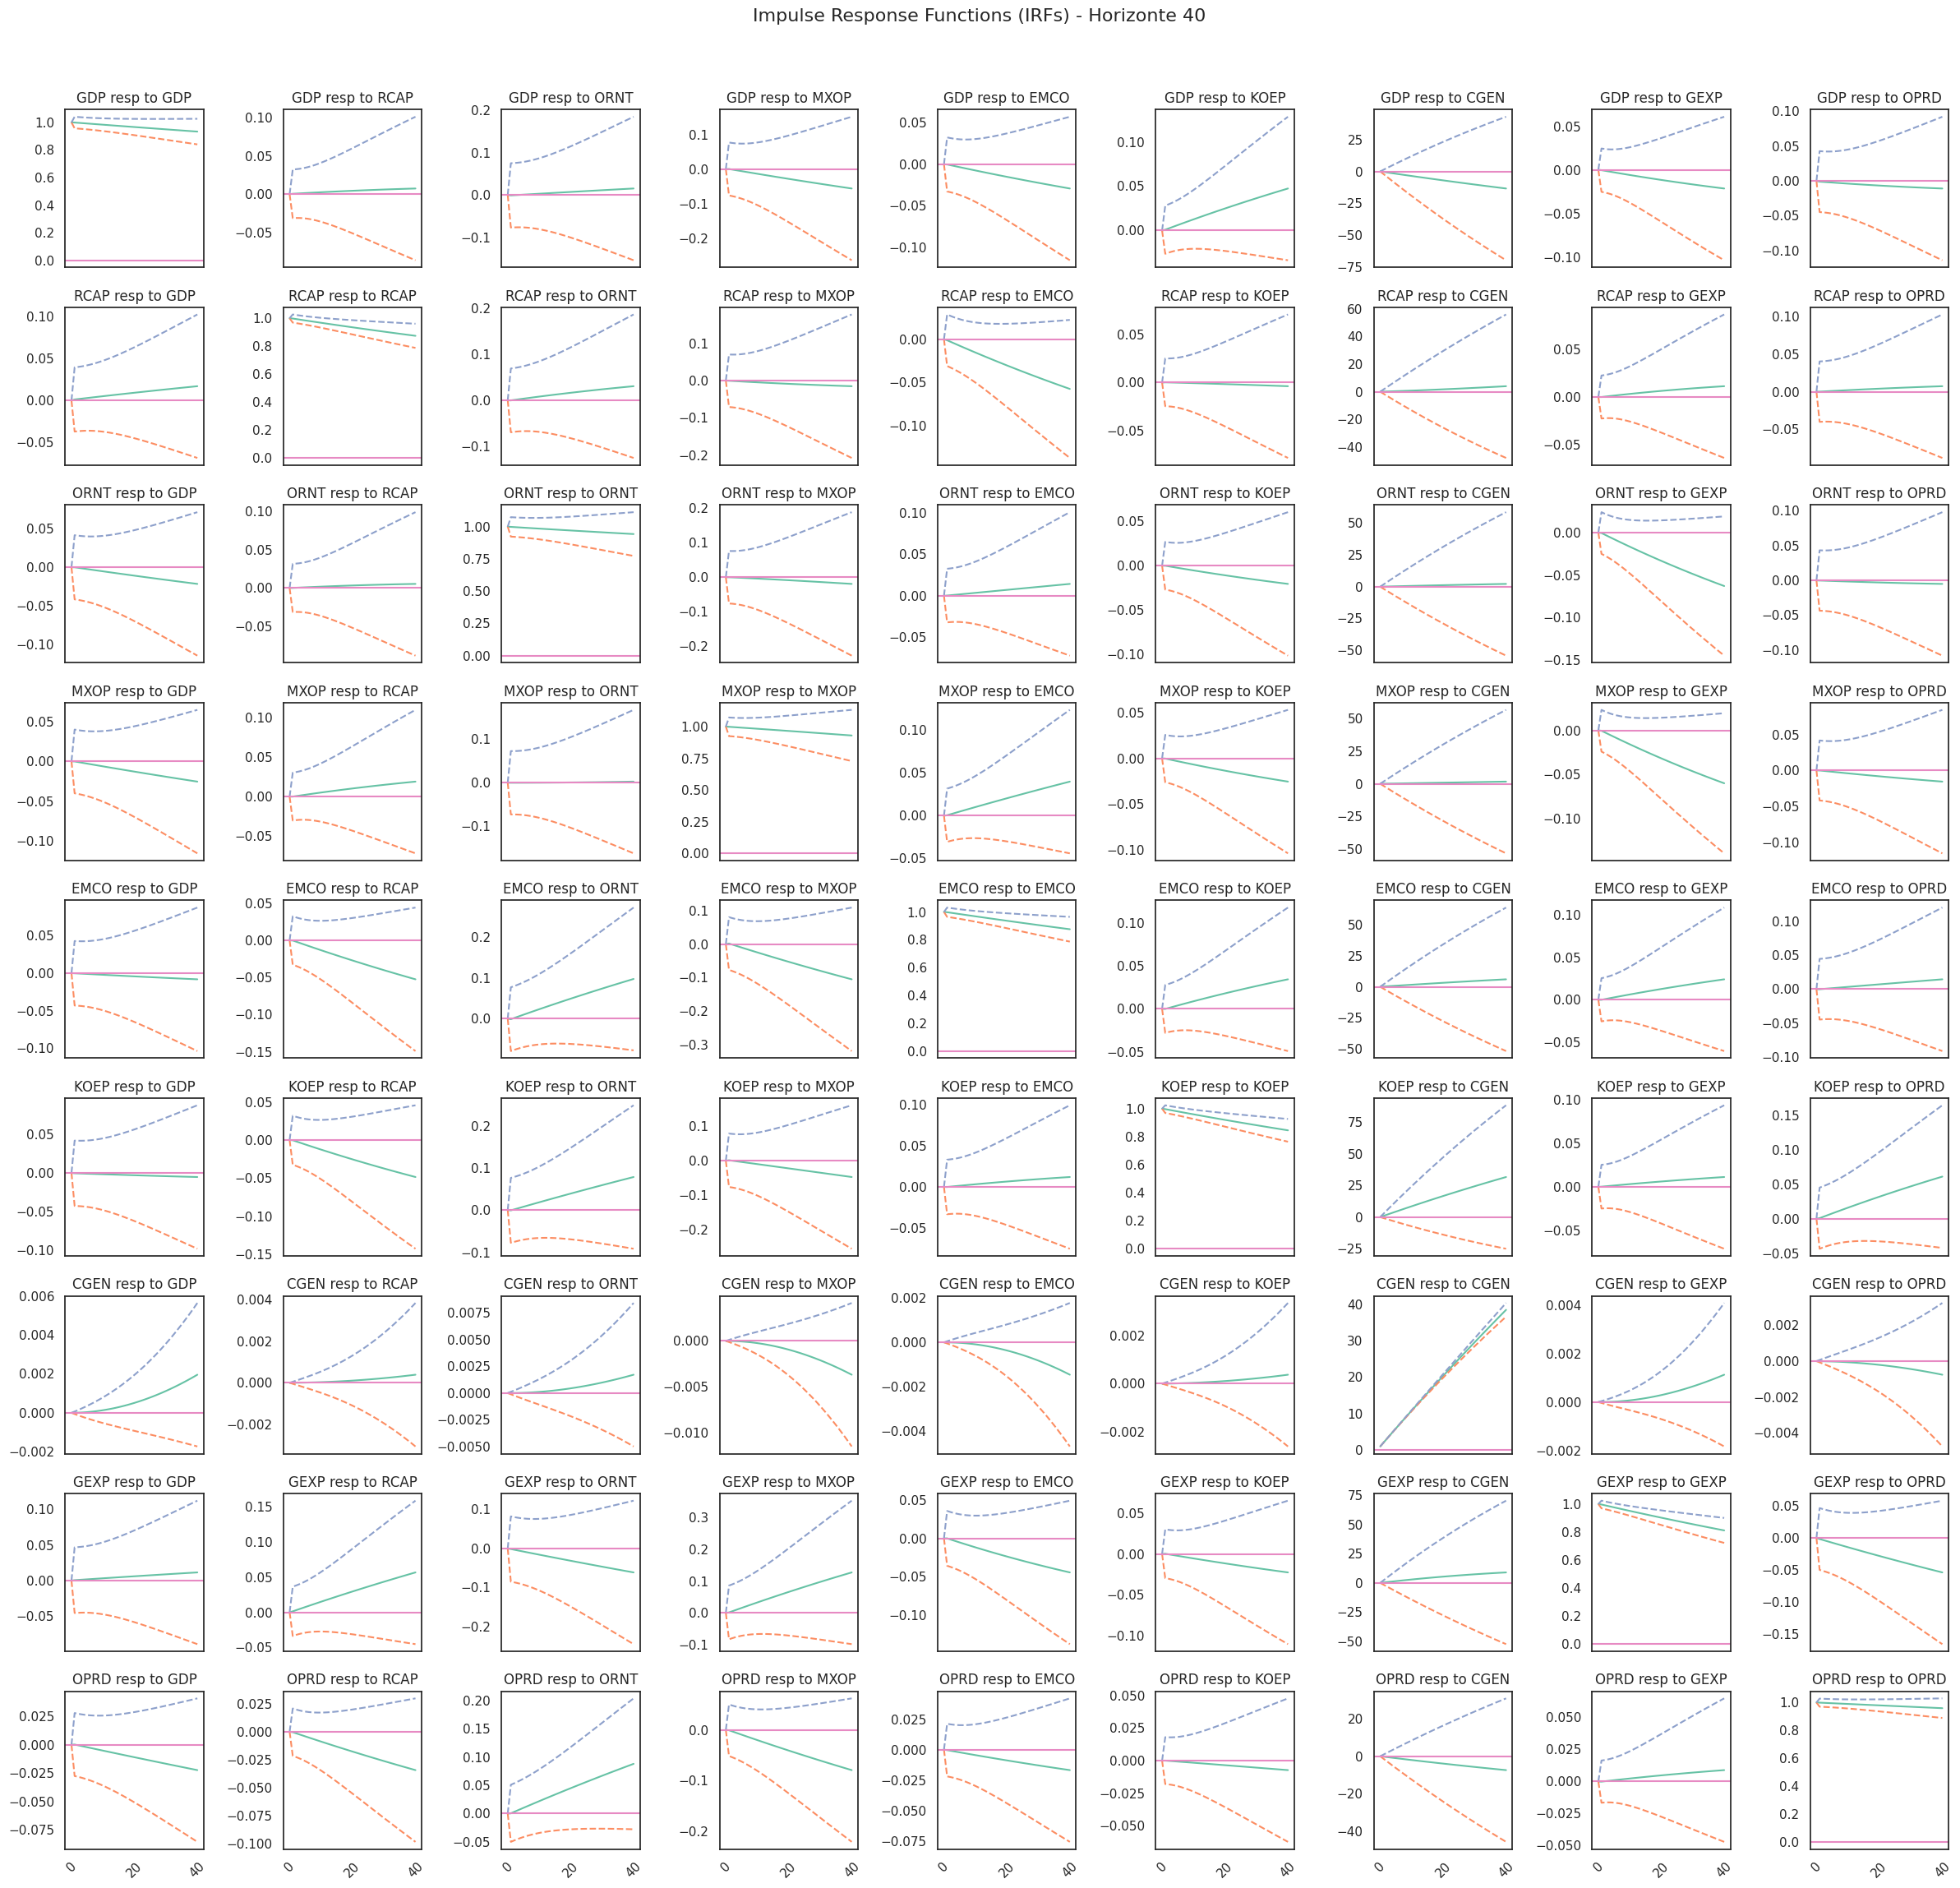

✅ FEVD guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Predicciones_finales/VAR/Sistema_VAR_Variables_interes_tesis//graficas_irf_fevd/FEVD_var_p=2.csv
✅ Imagen guardada en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Predicciones_finales/VAR/Sistema_VAR_Variables_interes_tesis//graficas_irf_fevd/FEVD_var_p=2_english.png


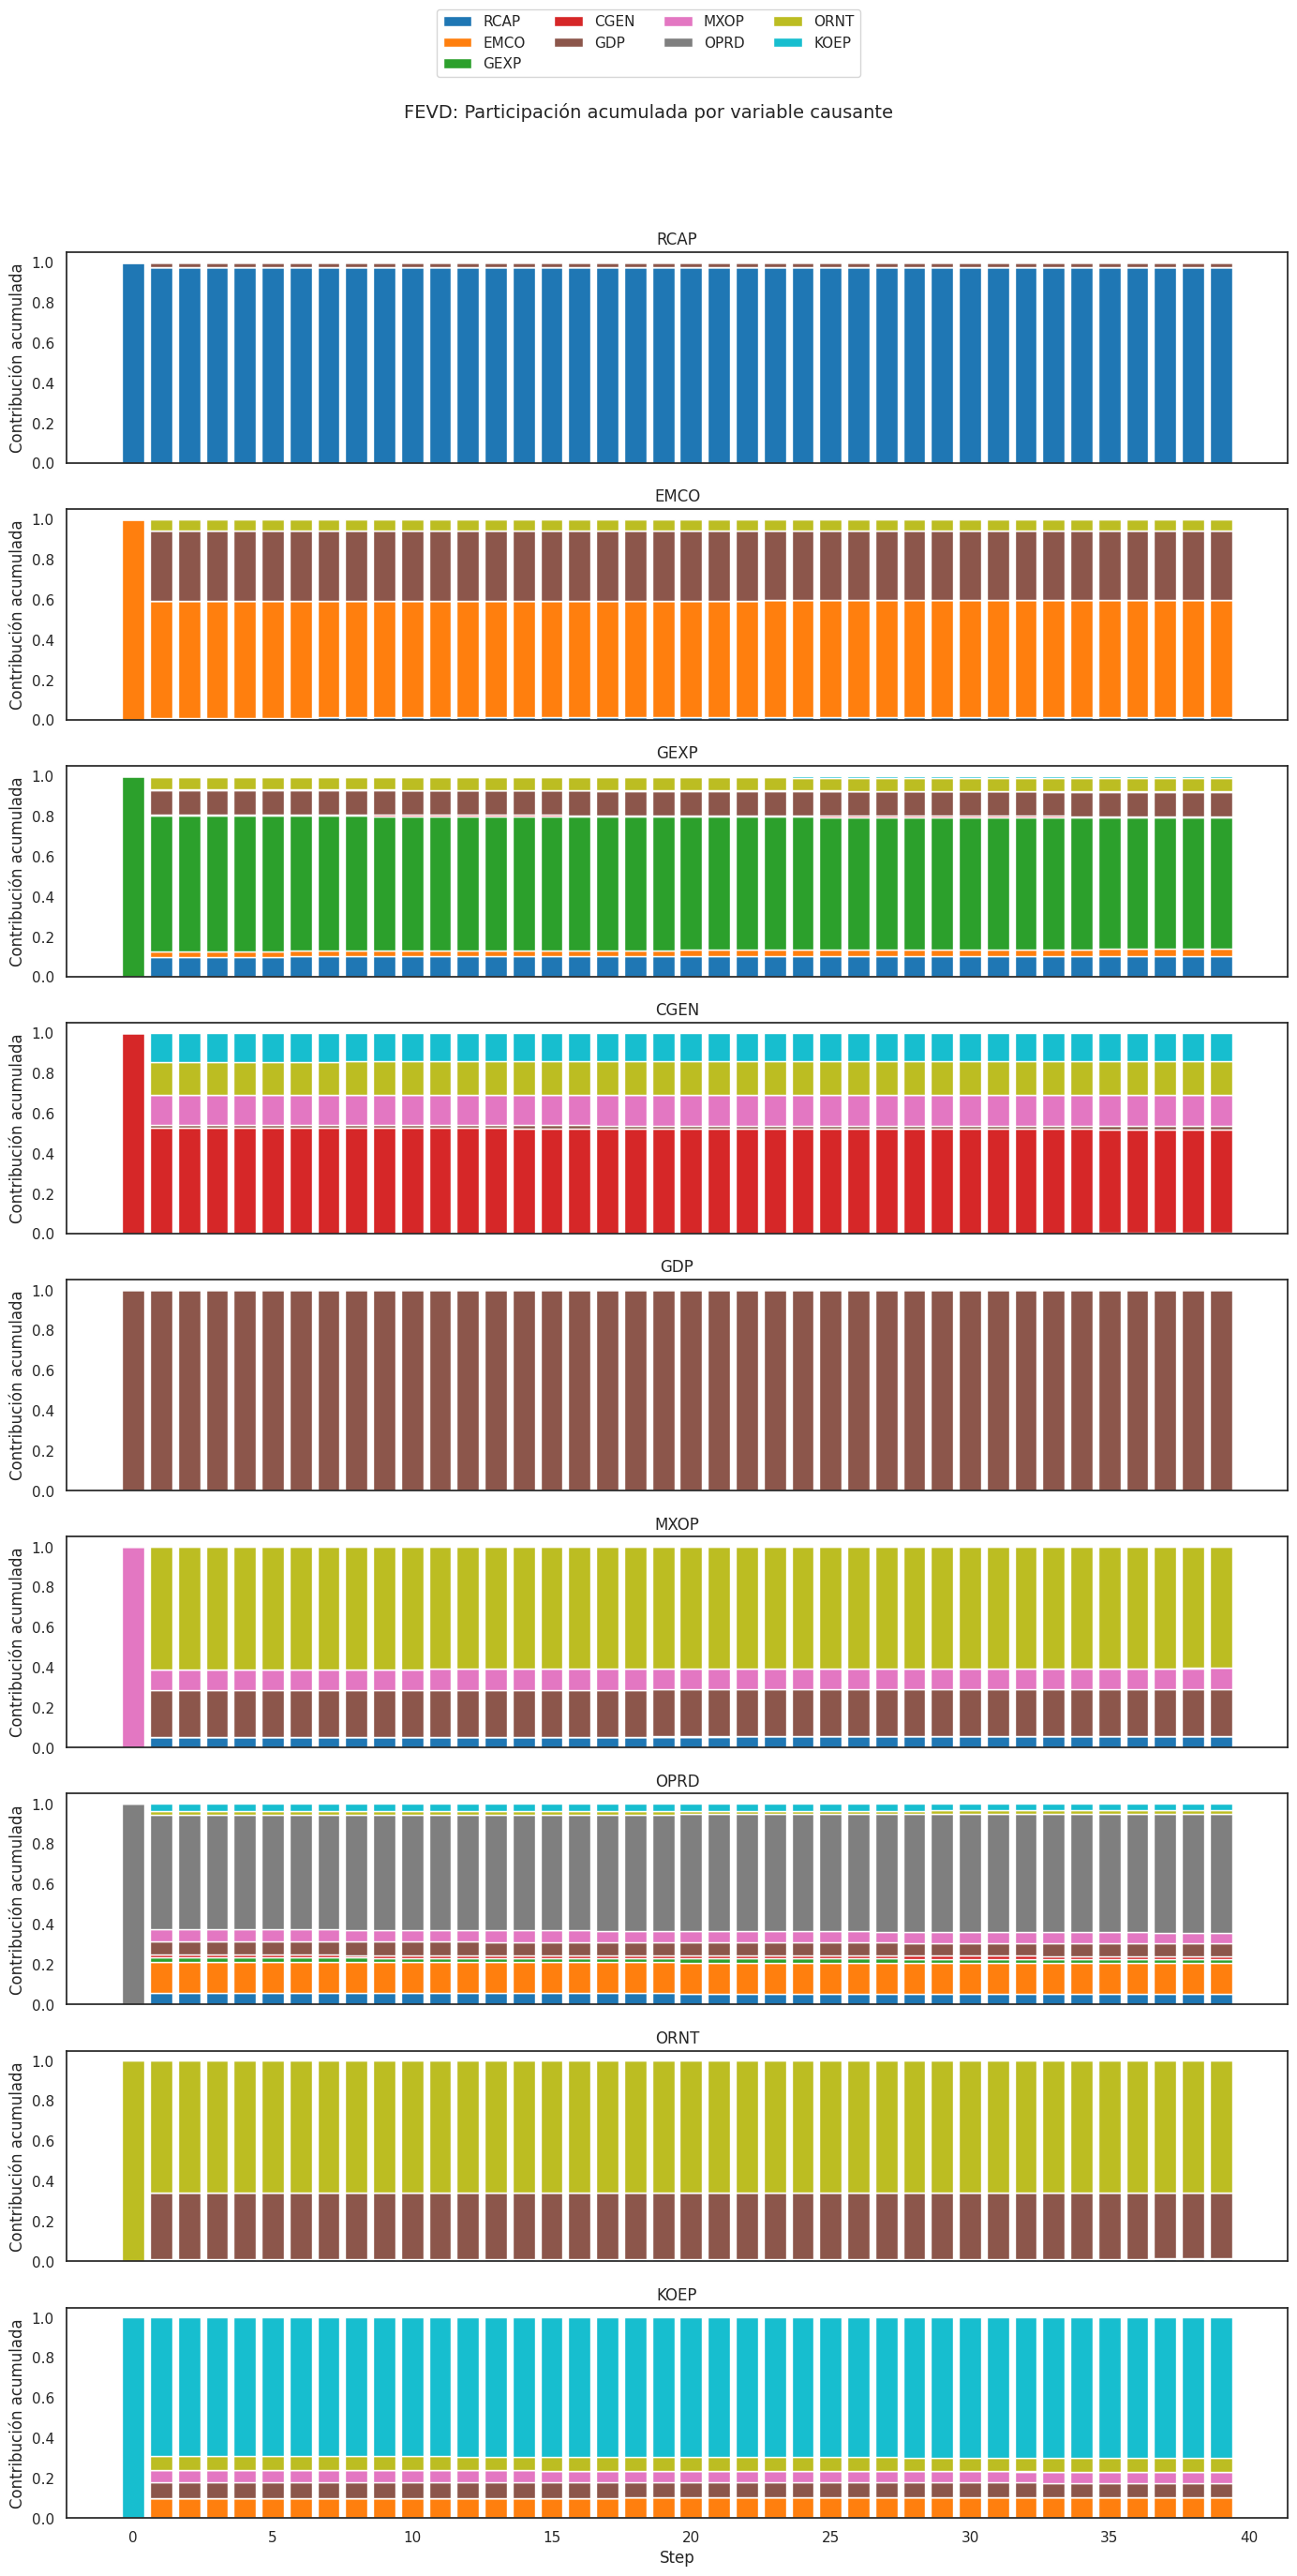

In [ ]:
# === 1. Calcular y graficar IRF ===
h=40
irf_df, _ = graficar_IRF(
    modelo_fitted=modelo_ganador,
    nombres_personalizados=costum_names,
    steps=40,
    nombre_modelo=f"var_p={mejor_p}_english",
    carpeta_salida=carpeta_salida
)

# === 2. Calcular FEVD manualmente (Cholesky) ===
fevd_df = calcular_FEVD_cholesky(modelo_ganador, steps=40,
                                  nombre_modelo=f"var_p={mejor_p}",
                                  carpeta_salida= carpeta_salida)

# === 3. Graficar FEVD para verificar visualmente ===
graficar_FEVD_desde_df(
    fevd_df,
    nombre_modelo = f'var_p={mejor_p}_english',
    nombres_personalizados = costum_names,
    carpeta_salida = carpeta_salida)

# === 4. Interpretación automática combinada FEVD + IRF ===
interpretaciones = interpretar_fevd_irf(
    fevd_df=fevd_df,
    irf_df=irf_df,
    paso_final=39,
    top_k=3,
    nombres_personalizados=costum_names,
    ruta_salida=carpeta_salida + f"/interpretaciones_english_IRF_FEVD_var_p={mejor_p}.txt"
)

# Backtesting multi paso tipo ventana deslizante

In [ ]:
# === Función para evaluar y graficar resultados ===
def evaluar_prediccion(y_real, y_pred, nombre='Modelo'):
    """
    Calcula MAE, RMSE y R² entre predicción y valores reales.
    """
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = 1 - np.sum((y_real - y_pred) ** 2) / np.sum((y_real - np.mean(y_real)) ** 2)
    print(f"\n🔍 Evaluación {nombre}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def backtesting_VAR_multistep_produccion(modelo, train_series, test_series,
                                         columna_objetivo, scaler,
                                         series_originales, h=5, reentrenar=True,
                                         ruta_resultados=None, graficar=True):
    """
    Realiza backtesting multistep (rolling) para el modelo VAR ganador, reconstruyendo la serie en escala original.

    Args:
        modelo: Modelo VAR ya entrenado.
        train_series (pd.DataFrame): Serie diferenciada y estandarizada de entrenamiento.
        test_series (pd.DataFrame): Serie diferenciada y estandarizada de prueba.
        columna_objetivo (str): Nombre de la columna a evaluar.
        scaler (StandardScaler): Objeto para invertir la estandarización.
        series_originales (pd.DataFrame): Serie sin transformar (sin diferencias ni escalamiento).
        h (int): Número de pasos de predicción.
        reentrenar (bool): Si True, se reentrena el modelo en cada iteración.
        ruta_resultados (str): Carpeta para guardar predicciones.
        graficar (bool): Si True, genera gráfica comparativa.

    Returns:
        dict: Métricas de evaluación (MAE, RMSE, R²).
    """
    import warnings
    from statsmodels.tools.sm_exceptions import ValueWarning

    # === Suprimir warning de frecuencia
    warnings.filterwarnings("ignore", category=ValueWarning)

    # === Forzar frecuencia si es posible
    for df in [train_series, test_series]:
        if df.index.freq is None:
            df.index.freq = pd.infer_freq(df.index)

    columnas = test_series.columns
    p = modelo.k_ar
    y_real_scaled = []
    y_pred_scaled = []

    for i in range(0, len(test_series) - h + 1, h):  # rolling multistep
        ventana_entrenamiento = pd.concat([train_series, test_series.iloc[:i]])

        if reentrenar:
            modelo_temp = VAR(ventana_entrenamiento).fit(p)
        else:
            modelo_temp = modelo

        forecast = modelo_temp.forecast(ventana_entrenamiento.values[-p:], steps=h)
        y_pred_scaled.append(forecast)
        y_real_scaled.append(test_series.iloc[i:i + h].values)

    # === Invertir estandarización ===
    y_pred_scaled = np.concatenate(y_pred_scaled)
    y_real_scaled = np.concatenate(y_real_scaled)
    y_pred_inv = scaler.inverse_transform(y_pred_scaled)
    y_real_inv = scaler.inverse_transform(y_real_scaled)

    # === Reconstruir diferencias para la columna objetivo ===
    idx = list(columnas).index(columna_objetivo)
    ultimo_valor_real = series_originales[columna_objetivo].iloc[len(train_series) - 1]
    y_pred = np.r_[ultimo_valor_real, y_pred_inv[:, idx]].cumsum()[1:]
    y_real = np.r_[ultimo_valor_real, y_real_inv[:, idx]].cumsum()[1:]

    # === Indexar y crear series para graficar ===
    fechas = test_series.index[:len(y_pred)]
    pred_series = pd.Series(y_pred, index=fechas)
    real_series = pd.Series(y_real, index=fechas)

    # === Guardar ===
    if ruta_resultados:
        os.makedirs(ruta_resultados, exist_ok=True)
        df_export = pd.DataFrame({'Real': real_series, 'Predicción': pred_series})
        df_export.to_excel(os.path.join(ruta_resultados, f"backtesting_VAR_h{h}.xlsx"))

    # === Evaluar ===
    metricas = evaluar_prediccion(real_series, pred_series, nombre=f"VAR (h={h})")
    # === Agregar predicción futura final de h pasos ===
    serie_total = pd.concat([train_series, test_series])
    if serie_total.index.freq is None:
      serie_total.index.freq = pd.infer_freq(serie_total.index)

    if reentrenar:
      modelo_final = VAR(serie_total).fit(p)
    else:
      modelo_final = modelo

    forecast_futuro = modelo_final.forecast(serie_total.values[-p:], steps=h)
    forecast_futuro_inv = scaler.inverse_transform(forecast_futuro)
    forecast_valores = np.r_[y_real[-1], forecast_futuro_inv[:, idx]].cumsum()[1:]

    # Fechas futuras
    ultima_fecha_test = test_series.index[-1]
    fechas_futuras = pd.date_range(start=ultima_fecha_test + pd.Timedelta(days=1), periods=h, freq='D')
    pred_futuro_series = pd.Series(forecast_valores, index=fechas_futuras)
    pred_futuro_series.index.name = 'Fecha'

    # === Guardar ===
    if ruta_resultados:
      pred_futuro_series.to_excel(os.path.join(ruta_resultados, f"prediccion_futura_VAR_h{h}.xlsx"))

# === Graficar ===
    if graficar:
      plt.figure(figsize=(15,6))
      series_originales[columna_objetivo].plot(label='Serie original completa', alpha=0.3, color='gray')
      real_series.plot(label='Real reconstruida (test)', color='blue')
      pred_series.plot(label='Predicción VAR (test)', color='red', linestyle='--')
      pred_futuro_series.plot(label='Predicción futura VAR (h pasos)', color='green', linestyle=':')
      plt.title(f'Backtesting VAR (h={h}) + Predicción futura')
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()

    return metricas, pred_futuro_series

In [ ]:
# Parámetros clave
h = 30       # Pasos al futuro
columna_objetivo = 'Capacidad instalada de energía renovables (MW)'  # Ajusta según tu interés
ruta_csv=ruta + f'resultados_backtesting_VAR_CIER(MW)_{mejor_p}'

# Backtesting rolling multistep VAR
metricas, predecir_futuro_hpasos = backtesting_VAR_multistep_produccion(
    modelo=modelo_ganador,
    train_series= train_series,                     # serie diferenciada, estandarizada y sin multicolinealidad
    test_series= test_series,
    columna_objetivo=columna_objetivo,
    scaler=scaler,                                  # el mismo que se usó para escalar
    series_originales=series_sin_multicolinealidad,
    h=h,
    reentrenar=True,
    ruta_resultados=ruta_csv

)

# Anexos importantes

# VAR, VECM y SVECM: extensiones y diferencias

## 1. VAR (Vector Autoregression)
- Modelo reducido que captura la dinámica conjunta de varias series estacionarias.  
- Se estima en **niveles** si las series son I(0) o en **diferencias** si son I(1) y no cointegradas.  
- Permite análisis mediante:
  - **Impulse Response Functions (IRFs)**
  - **Generalized IRFs (GIRFs)**
  - **Forecast Error Variance Decomposition (FEVD)**
  - **Granger causality tests**

⚠️ **Limitación:** si las series son I(1) y están cointegradas, un VAR en diferencias ignora la información del equilibrio de largo plazo.

---

## 2. VECM (Vector Error Correction Model)
- Extiende el VAR para variables **I(1) cointegradas**.  
- Ecuación general:  

$$
\Delta \mathbf{y}_t = \alpha \beta^\top \mathbf{y}_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta \mathbf{y}_{t-i} + \varepsilon_t
$$

- **Novedades clave:**
  - $\beta$: vectores de cointegración (relaciones de **largo plazo**).  
  - $\alpha$: velocidades de ajuste (qué tan rápido las variables corrigen desviaciones).  
- Permite separar:
  - **Corto plazo** → dinámicas de las diferencias.  
  - **Largo plazo** → equilibrio capturado por el término de corrección de error.  

✅ **Qué se mantiene del VAR:**  
- IRFs, GIRFs, FEVD y Granger siguen aplicando.  
- Ahora además se puede interpretar:
  - Granger de corto plazo (coeficientes de $\Delta y$).  
  - Granger de largo plazo (significancia de $\alpha$).  

---

## 3. SVAR (Structural VAR)
- Introduce **restricciones económicas** para identificar choques estructurales.  
- Dos tipos de restricciones:
  - **Corto plazo (contemporáneas)** → matriz A.  
  - **Largo plazo** → restricciones en acumulación de respuestas (ej. Blanchard–Quah).  
- Permite distinguir choques **estructurales** (ej. oferta vs demanda de petróleo).

---

## 4. SVECM (Structural VECM)
- Es la combinación de VECM + identificación estructural.  
- Adecuado cuando las series están cointegradas **y** se busca diferenciar choques permanentes y transitorios.  
- Ecuación:  

$$
\Delta \mathbf{y}_t = \alpha \beta^\top \mathbf{y}_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta \mathbf{y}_{t-i} + A^{-1}B u_t
$$

- **Ventaja principal:**  
  - Permite separar choques que **desplazan el equilibrio de largo plazo** (permanentes) de los que son solo **transitorios**.  

**Ejemplo en energía:**  
- Un choque de **precio del petróleo** puede tener un efecto **permanente** en la relación PIB–renta–gasto.  
- Un choque de **gasto público** puede ser **transitorio**, ajustándose de vuelta al equilibrio.

---

## 📌 Resumen comparativo

| Modelo  | Cuándo usarlo | Qué ofrece |
|---------|---------------|------------|
| **VAR** | Series estacionarias (I(0)) o I(1) sin cointegración | Dinámica conjunta de corto plazo |
| **VECM** | Series I(1) cointegradas | Corto y largo plazo, corrección de error |
| **SVAR** | Identificación estructural en VAR | Distinguir choques estructurales (ej. oferta vs demanda) |
| **SVECM** | Series cointegradas + interés en choques estructurales | Separar choques permanentes vs transitorios |


# 📌 2 Anexo metodológico: De VAR a SVAR

## 1. VAR reducido
El modelo VAR es el punto de partida:

\[
Y_t = A_1 Y_{t-1} + \dots + A_p Y_{t-p} + u_t
\]

- Cada variable depende de sus propios rezagos y de los de las demás.  
- Los errores \(u_t\) suelen estar correlacionados contemporáneamente → los **shocks no son puros**.  
- IRF/FEVD permiten explorar la dinámica, pero los resultados dependen del **orden de las variables**.

---

## 2. Extensión a SVAR
El SVAR introduce restricciones estructurales para identificar shocks con interpretación económica:

\[
A Y_t = A_1 Y_{t-1} + \dots + A_p Y_{t-p} + B \varepsilon_t
\]

- **Matriz A**: relaciones contemporáneas entre variables.  
  - `1`: normalización (diagonal).  
  - `0`: restricción fuerte (no hay efecto contemporáneo).  
  - `nan`: libre, el modelo lo estima.  
- **Matriz B**: estructura de los shocks estructurales (por defecto \(B = I\)).  
- Los shocks \(\varepsilon_t\) ya no son estadísticos, sino **estructurales** (ej. shock de gasto público, shock educativo).

---

## 3. Ejemplo de matriz A
Orden de variables: **[gasto_pub, edu_inv, balanza, gdp]**

|               | gasto_pub | edu_inv | balanza | gdp |
|---------------|-----------|---------|---------|-----|
| **gasto_pub** | 1         | 0       | 0       | 0   |
| **edu_inv**   | nan       | 1       | 0       | 0   |
| **balanza**   | nan       | nan     | 1       | 0   |
| **gdp**       | nan       | nan     | nan     | 1   |

📌 **Lectura**:  
- El gasto público es exógeno contemporáneo (no recibe de nadie).  
- La inversión educativa responde al gasto.  
- La balanza responde al gasto y a la educación.  
- El PIB responde a todas las anteriores.

---

## 4. Triangulación y orden
- La forma triangular (recursiva) es el **baseline recomendado**:  
  - Facilita la identificación.  
  - Claridad: las primeras variables son más “exógenas”, las últimas más “endógenas”.  
- **Limitación**: los resultados dependen del orden elegido.  
  - En un ciclo expansivo, puede ser razonable gasto→PIB.  
  - En crisis, podría justificarse PIB→gasto.  
- Buenas prácticas:
  1. Elegir un orden defendible con teoría/literatura.  
  2. Probar órdenes alternativos como robustez.  
  3. Comparar con GIRF (no dependen del orden, aunque no identifican shocks estructurales).  
  4. Explorar restricciones de signo o largo plazo si la triangulación no es convincente.

---

## 5. Complemento VAR ↔ SVAR
- **VAR reducido**: describe la dinámica general (IRF, FEVD, Granger), útil para exploración.  
- **SVAR**: añade teoría mediante restricciones → los shocks pasan a ser **estructurales y económicos**.  
- En conjunto:  
  - VAR = base estadística.  
  - SVAR = interpretación causal con sustento económico.

---

## 6. Código mínimo en Python
```python
from statsmodels.tsa.vector_ar.svar_model import SVAR
import numpy as np

names = ['gasto_pub','edu_inv','balanza','gdp']
p = 2  # rezagos seleccionados con VAR reducido
k = len(names)

A = np.eye(k)
A[1,0] = np.nan   # gasto → edu
A[2,0] = np.nan   # gasto → balanza
A[2,1] = np.nan   # edu → balanza
A[3,0] = np.nan   # gasto → PIB
A[3,1] = np.nan   # edu → PIB
A[3,2] = np.nan   # balanza → PIB

svar = SVAR(endog=df[names], svar_type='A', A=A, order=p).fit()
svar.irf(20).plot(impulse='edu_inv', response='gdp')
